# 1. Imports, Data Loading, and Dataset Creation

In [1]:
import sys
import os

# Get the directory path of the notebook
notebook_directory = os.path.dirname(os.path.abspath("__file__"))

# Get the directory path of the project (one level up)
project_directory = os.path.dirname(notebook_directory)

# Add the project directory to the Python module search path
sys.path.append(project_directory)

# Now you can import the LoadJSON module from DataLoaderLocal
from shared_utilities.DataLoaderLocal import LoadReviews

import pandas as pd
import utility_func as utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Adjust display options to show all columns
pd.set_option('display.max_columns', None)

In [3]:
reviews = LoadReviews()

utils.YelpDatasets_Reviews(reviews_df = reviews)


Reviews DataFrame's head:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
75,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26
93,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4,0,0,0,Don't know what it is but If my tummy's feelin...,2012-02-01 14:21:25
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04


In [4]:
reviews = reviews.sample(n = 50000, random_state = 42)
display(reviews)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3072330,0MFy30StA0Ns8ILccsowyA,S-cMvM-TbIg1oYMLPneoBg,43MDfrU28FYjfpamNfL9GA,4,2,0,0,Great food and environment. Loved the wine.\n\...,2013-11-30 22:31:33
3716689,LWER5lk9yGVoKr36yYxKsQ,RIXIoCTafjr1auUJkV3fLg,r6Unwg-mxv_3JrEjQ24_TQ,4,0,0,0,This Costco has very helpful staff and is alwa...,2014-06-06 23:02:11
6289074,pIdyWcCclKeplPN8D4Ft2A,a2DGFEIov1L7X9rKdVmN6A,xuYPogbBSHAtOebONVhprA,5,3,0,3,We have been coming here our whole lives and w...,2021-06-23 02:54:36
3245132,hWhJGNQEZRXWiBDp2XR2sw,DT0Elf41cptTnuz16auxKQ,lC0_e8F1zAstzhj-O3eQZg,5,0,0,0,This place is a must when you come Tucson! I'm...,2020-01-23 20:10:01
442448,fOKCRjS5DMGj4uCKvkcNUA,7F7Z-PCZjfxie15f9vl8ww,8QJTzIaR5FceGds8HBSIig,5,0,0,0,We loved our visit at Barrio today. They had a...,2017-09-17 22:39:09
...,...,...,...,...,...,...,...,...,...
6573320,K_7mBVWW7WpvrRIoehN2tg,1h-qSEwbpis0msbeIv15hQ,tszRCO-RchPXPZlsTCYgbA,1,1,0,0,SO disappointing. Took out of town guests afte...,2013-12-02 04:26:34
1273507,soYb-5uBROQ9l3xSl5sTFw,EAHCCgMFoJxlOPcCPQ91SQ,8YM2oTP6LZYQlwB6Hk9lLA,5,2,0,1,Came on a Wednesday night with friends from th...,2019-12-24 23:33:52
2026866,C-cz-XICTQxE_mcpTCjhdQ,RSHYLY1ypXEBd8pckrZfiA,xNZMbdl8ga_wjBPFMZOsyQ,1,2,0,0,"Absolutely terrible service, dead bug in my ri...",2019-06-16 07:45:49
1665638,Az6XBFwUXXp5tPOVGbvt2g,Vk8vZOJn2aFgRa-N6bmC6g,3pamD1Qj7MXrF6dglK_guQ,3,0,1,0,"The atmosphere at Club Congress is awesome, ve...",2008-07-07 22:38:01


In [5]:
#1 and 2 stars = -1 while 4 and 5 stars = +1
df = reviews.copy()
df = df[df['stars'] != 3]
df['sentiment'] = df['stars'].apply(lambda rating : +1 if rating > 3 else -1)

df_num = df.copy()

# Assuming replacing -1 and 1 with negative and positive respectively
df['sentiment'] = df['sentiment'].replace({-1: 'negative', 1: 'positive'})

df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
df_num['date'] = pd.to_datetime(df_num['date']).dt.strftime('%Y-%m')

# Dividing the reviews to positive and negative
pos = df[df['sentiment']=='positive'][['review_id','business_id','date','sentiment']]
neg = df[df['sentiment']=='negative'][['review_id','business_id','date','sentiment']]

#Preprocessing data
# change the structure of date column
#group by date and review_id to get the number of reviews per month and year
pos_pp = utils.preprocess_sentiment_df(pos)
neg_pp = utils.preprocess_sentiment_df(neg)

#Here we are going to sum the number of positive and negative reviews per month and year
#group by date and review_id to get the number of reviews per month and year
df_num = df_num.groupby(['date'])['sentiment'].sum().reset_index()
df_num['date'] = pd.to_datetime(df_num['date'])
df_num = df_num.sort_values(by='date')
df_num.rename(columns={'sentiment': 'sentiment_count_diff'}, inplace=True)

In [6]:
# change the structure of date column
reviews['date'] = pd.to_datetime(reviews['date']).dt.strftime('%Y-%m')
#group by date and review_id to get the number of reviews per month and year
reviews_per_month = reviews.groupby(['date'])['review_id'].count().reset_index()
reviews_per_month.columns = ['date', 'count']
reviews_per_month['date'] = pd.to_datetime(reviews_per_month['date'])
reviews_per_month = reviews_per_month.sort_values(by='date')
# Extract the year and month from the 'date' column
reviews_per_month['year'] = reviews_per_month['date'].dt.year
reviews_per_month['month'] = reviews_per_month['date'].dt.month

In [7]:
# Extracting the year from the date
count_rev_bus = reviews.groupby(['business_id', 'date'])['review_id'].count().reset_index()
count_rev_bus.columns = ['business_id', 'date', 'count']
count_rev_bus['date'] = pd.to_datetime(count_rev_bus['date'])
count_rev_bus = count_rev_bus.sort_values(by=['date','business_id'])
count_rev_bus['year'] = count_rev_bus['date'].dt.year

In [21]:
pos_pp_reg = utils.PrepareDataRegression(pos_pp, n_lag_features = 36)
neg_pp_reg = utils.PrepareDataRegression(neg_pp, n_lag_features = 36)

# 2. EDA - Exploratory Data Analysis

## 2.1. EDA - Times series analysis using ACF

<Figure size 1200x3000 with 0 Axes>

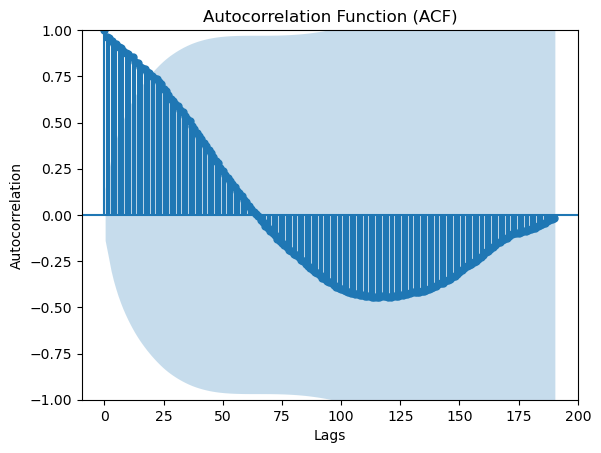

In [22]:
plt.figure(figsize=(12, 30))
plot_acf(pos_pp['review_id'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

ValueError: could not broadcast input array from shape (173,) into shape (191,)

<Figure size 1200x600 with 0 Axes>

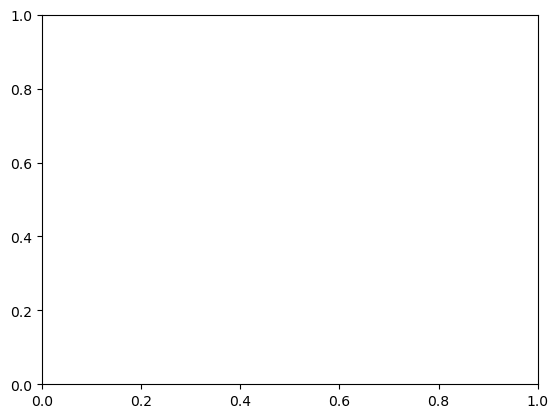

In [23]:
plt.figure(figsize=(12, 6))
plot_acf(neg_pp['review_id'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

<Figure size 1200x600 with 0 Axes>

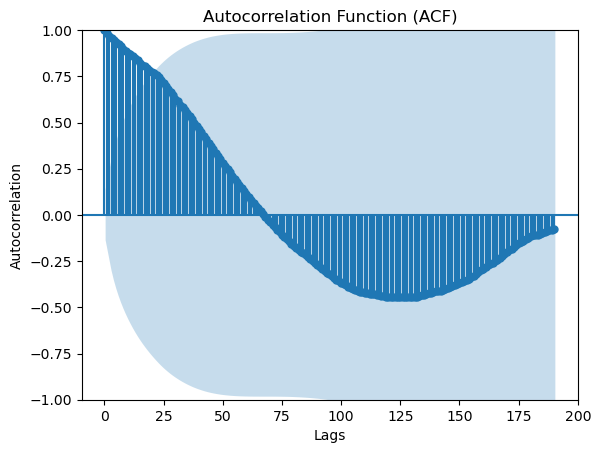

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(reviews_per_month['count'].values.squeeze(), lags=190)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.show()

## 2.2. EDA - Times series for Number of Reviews (regardless of the sentiment)

In [24]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Number of reviews', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

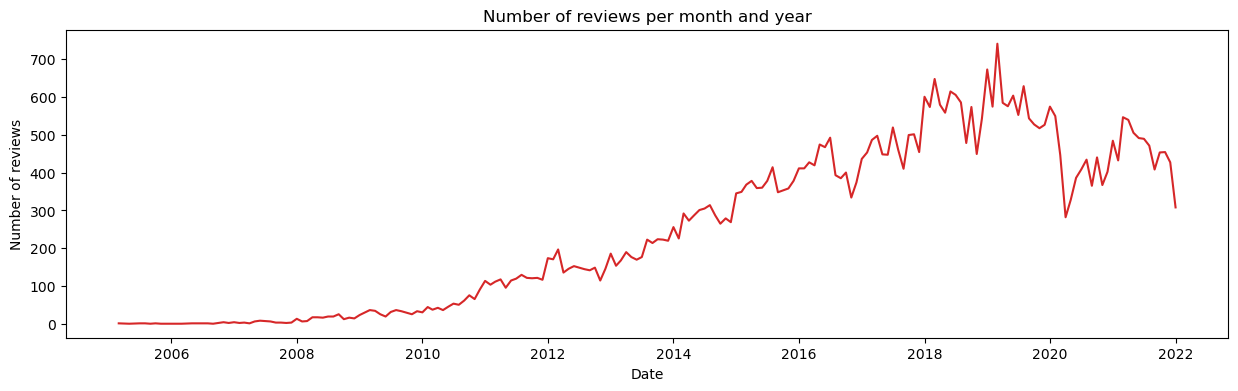

In [25]:
plot_df(x=reviews_per_month['date'], y=reviews_per_month['count'], title='Number of reviews per month and year')

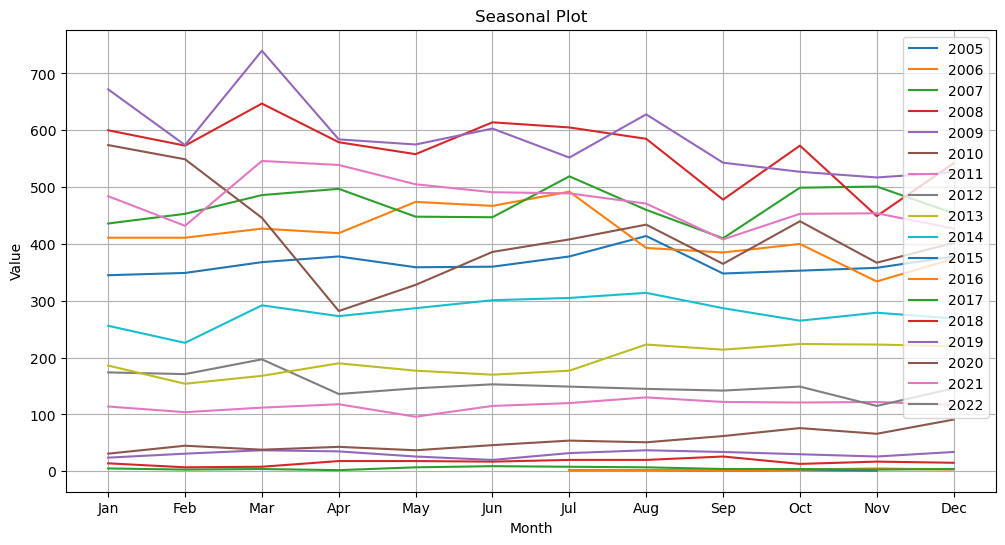

In [26]:
utils.SeasonalPlot(reviews_per_month)

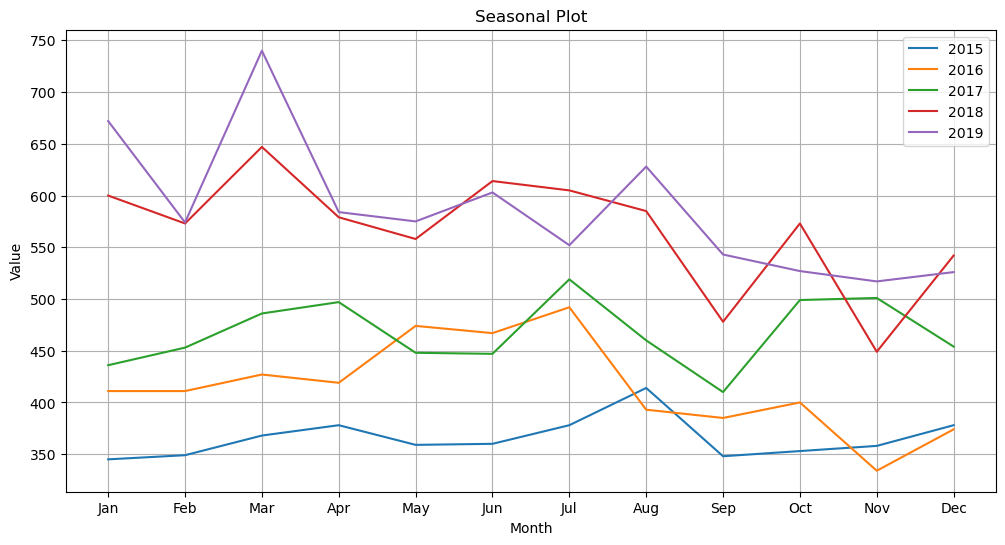

In [27]:
utils.SeasonalPlot(reviews_per_month, [2015, 2016, 2017, 2018, 2019])

### 2.2.1. EDA - Times series for Top 5 businesses in Tucson with the highest ammount of reviews 

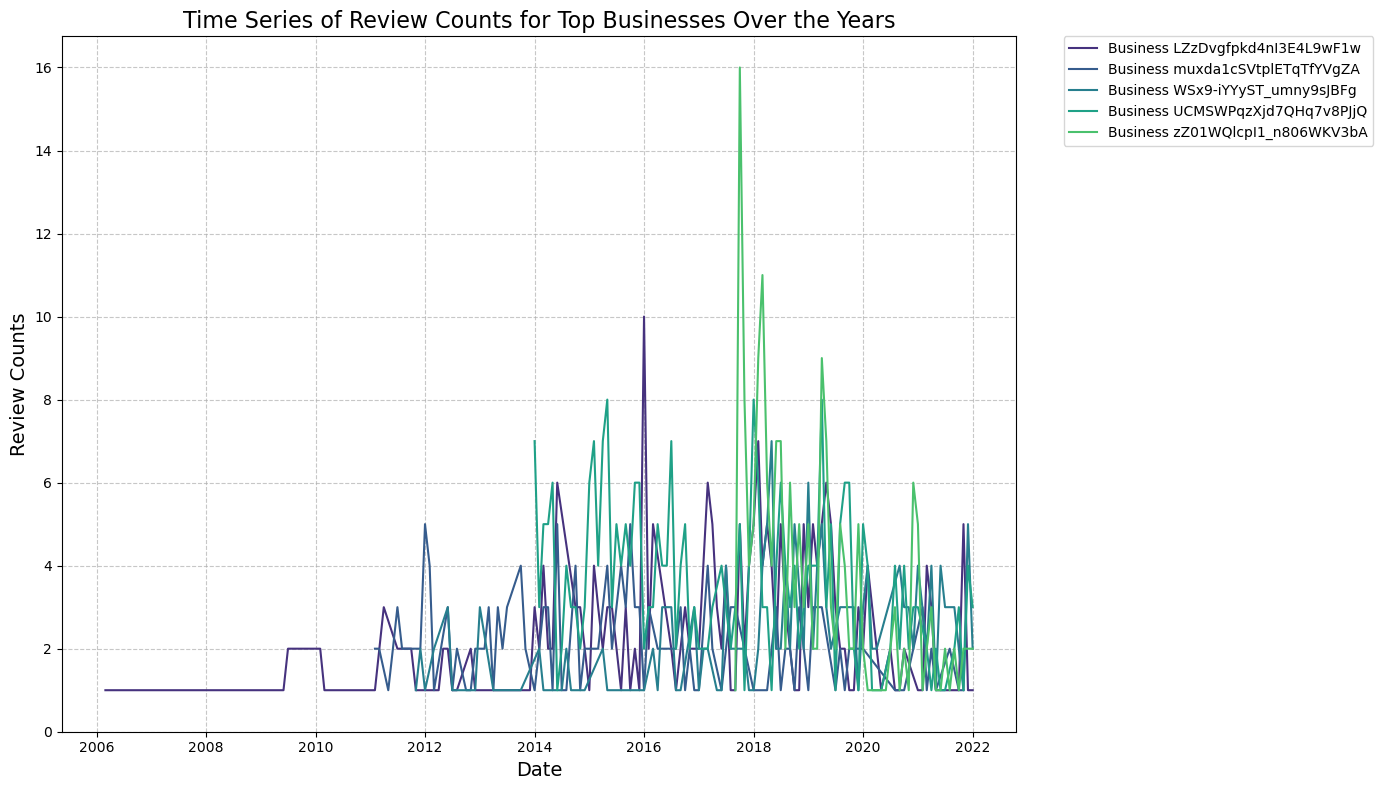

In [28]:
# Assuming you have a list of top businesses called 'top_businesses_list'
top_businesses_series = count_rev_bus.groupby(['business_id'])['count'].sum().sort_values(ascending=False).head(5)
utils.plot_top_businesses_over_time(count_rev_bus, top_businesses_series)

### 2.2.2. EDA - Times series decomposition

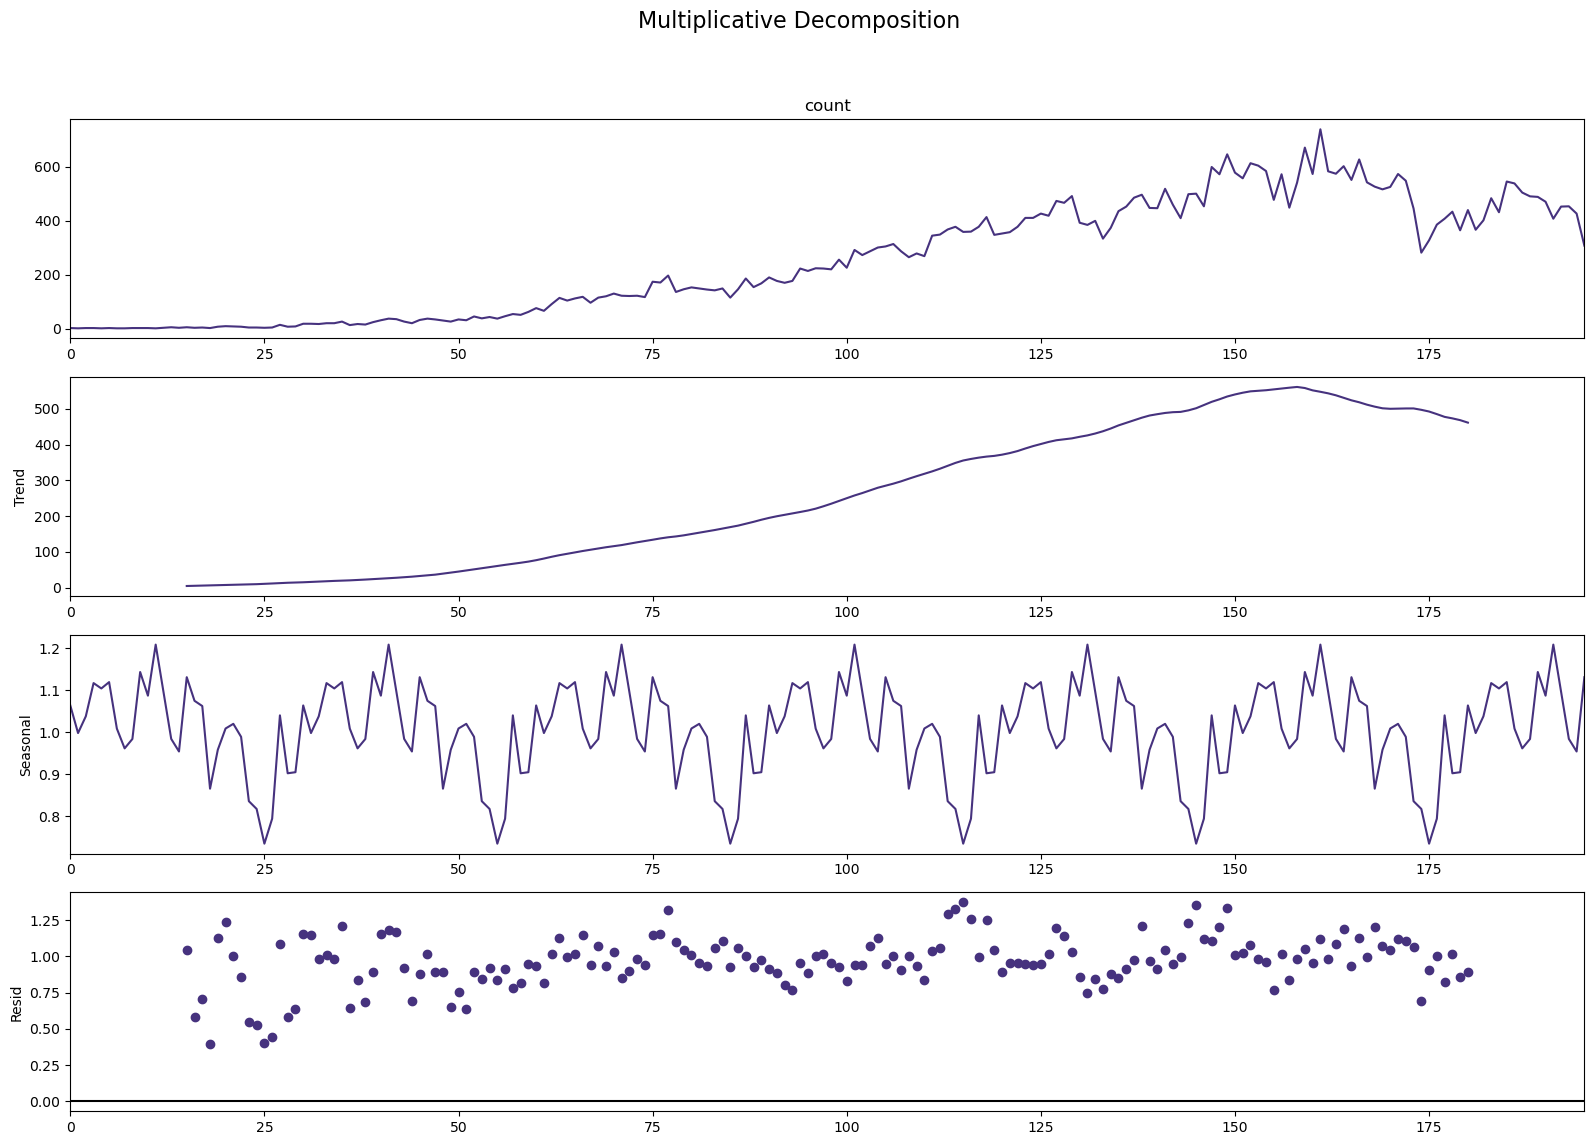

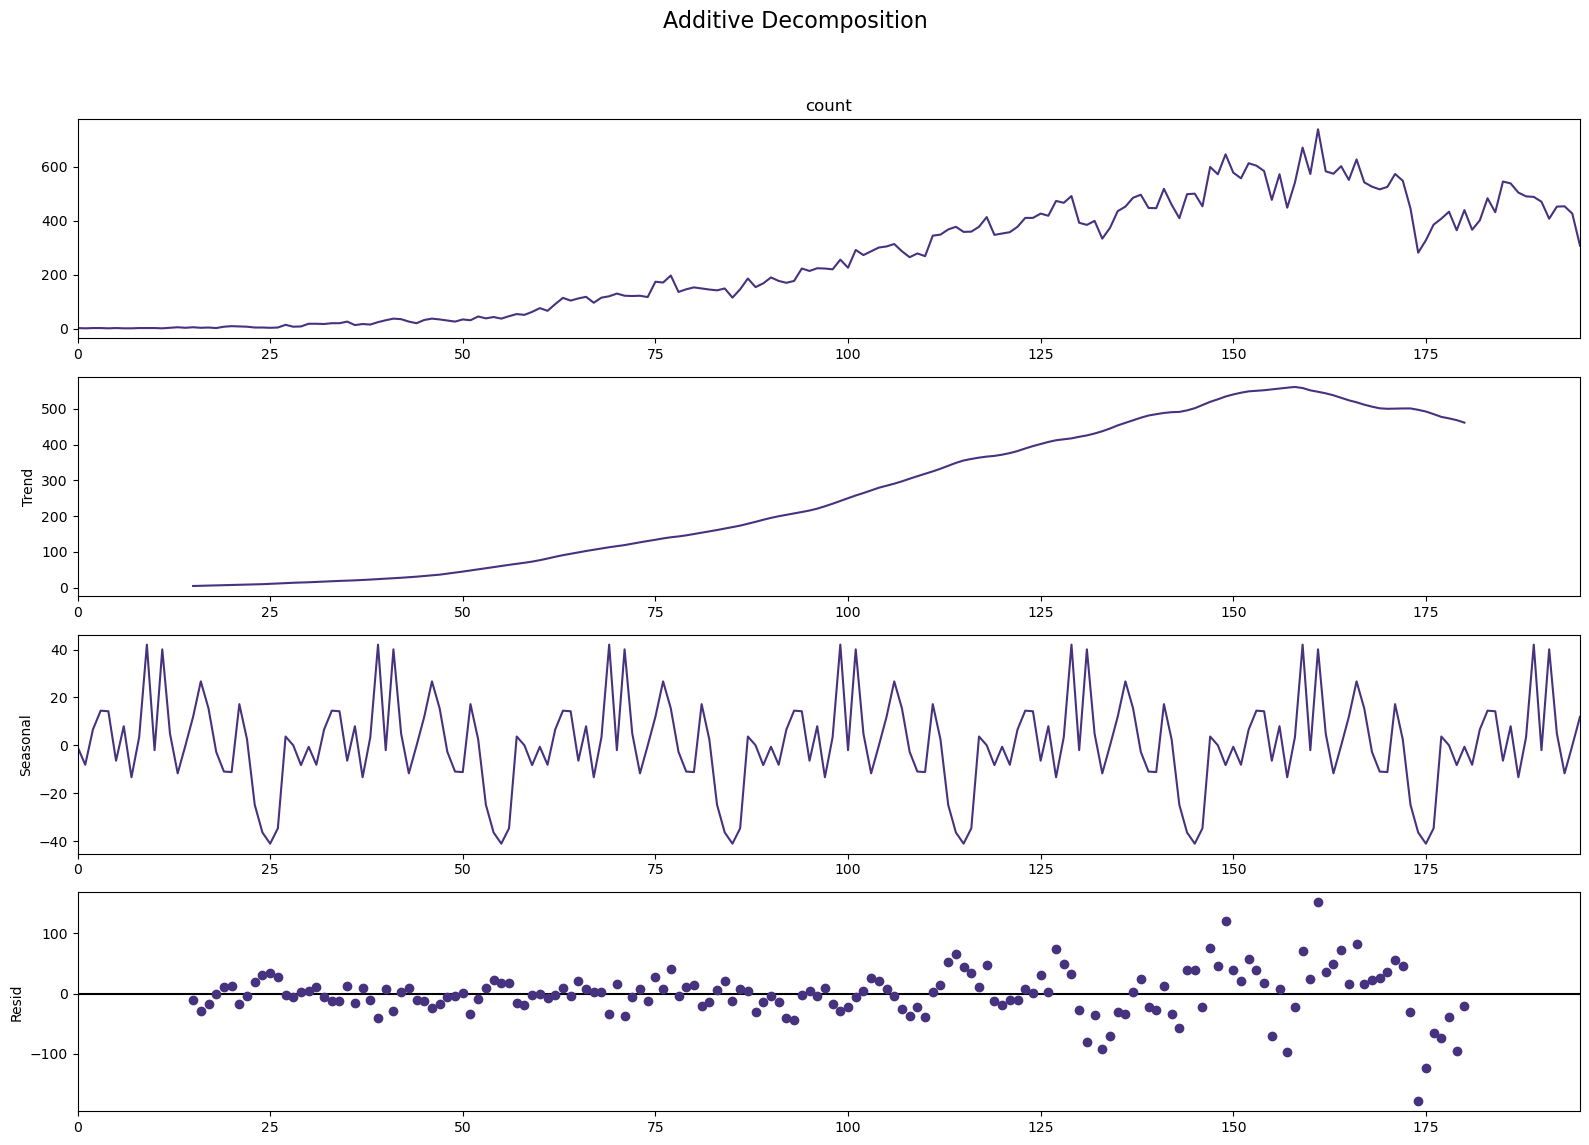

In [29]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(reviews_per_month['count'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(reviews_per_month['count'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## EDA 2.3. - Time series of review counts segregated by sentiments

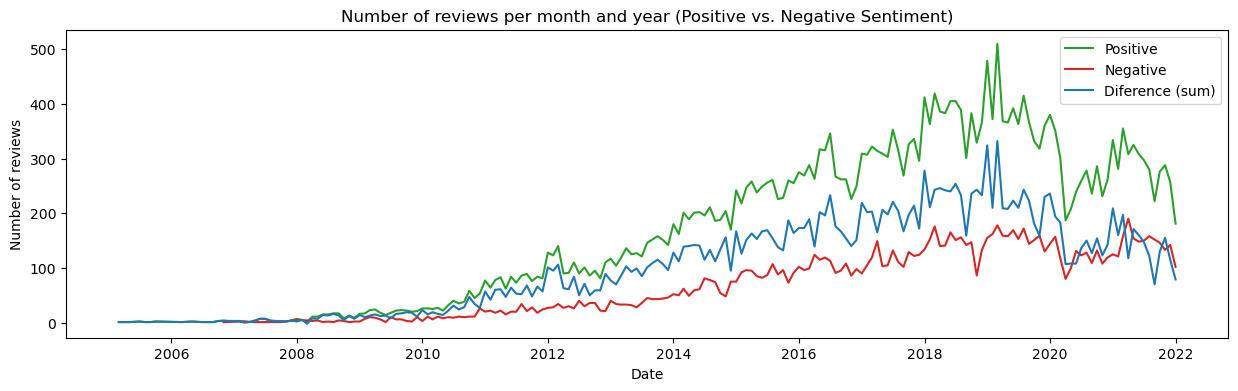

In [30]:
#Visualize the number of reviews per month and year (Positive vs. Negative Sentiment) and the sentiment sum 
utils.plot_df(x_pos=pos_pp['date'], y_pos=pos_pp['review_id'],
              x_neg=neg_pp['date'], y_neg=neg_pp['review_id'],
              x_df_num=df_num['date'], y_df_num=df_num['sentiment_count_diff'],
              title='Number of reviews per month and year (Positive vs. Negative Sentiment)')

### EDA 2.3.1. - Time series decomposition

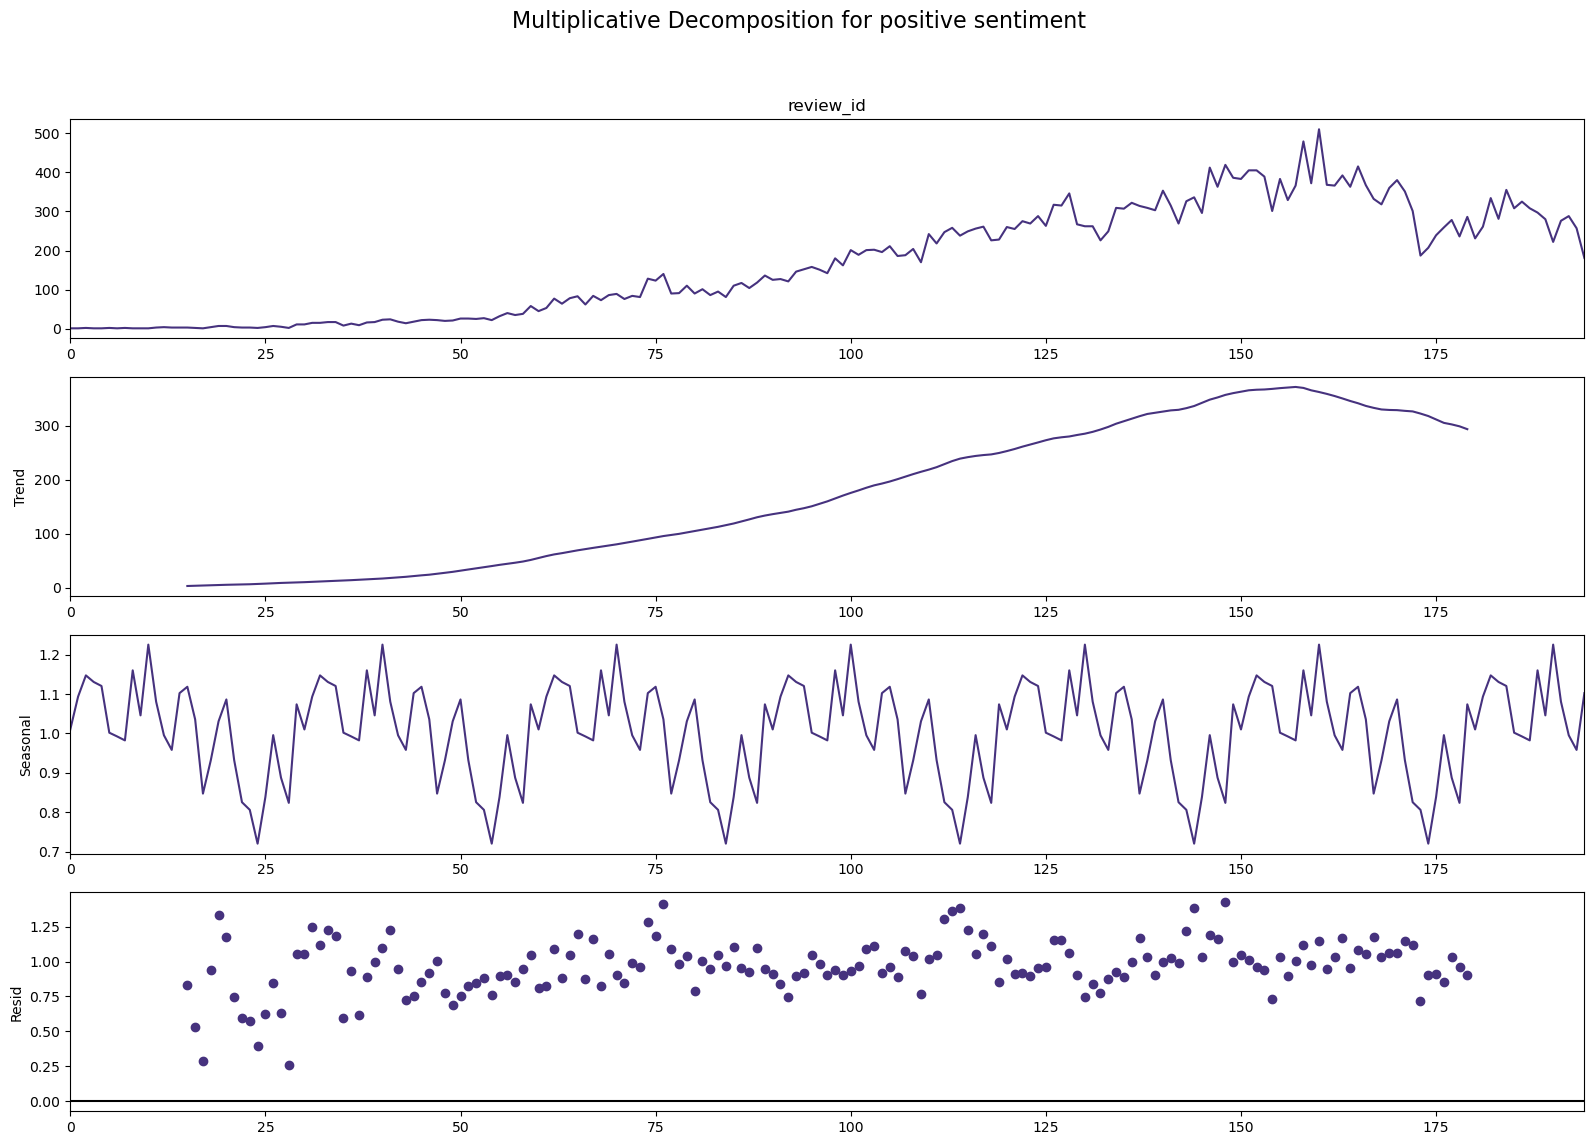

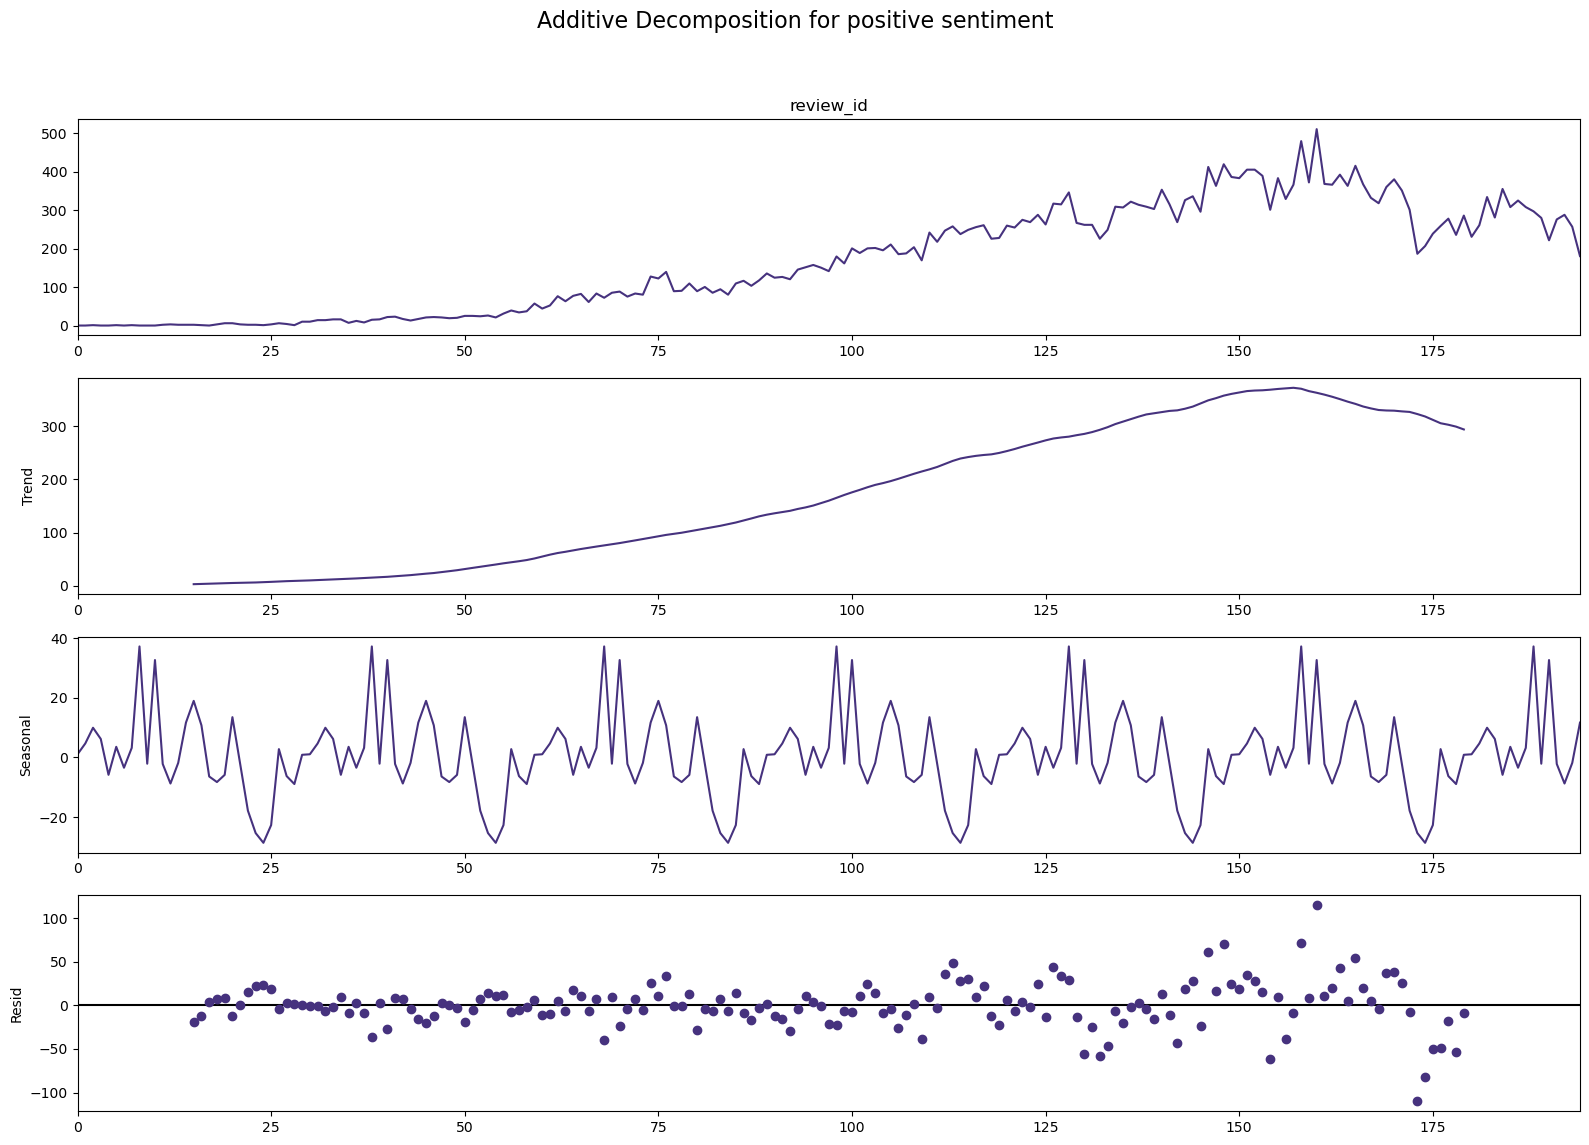

In [31]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(pos_pp['review_id'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(pos_pp['review_id'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for positive sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for positive sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

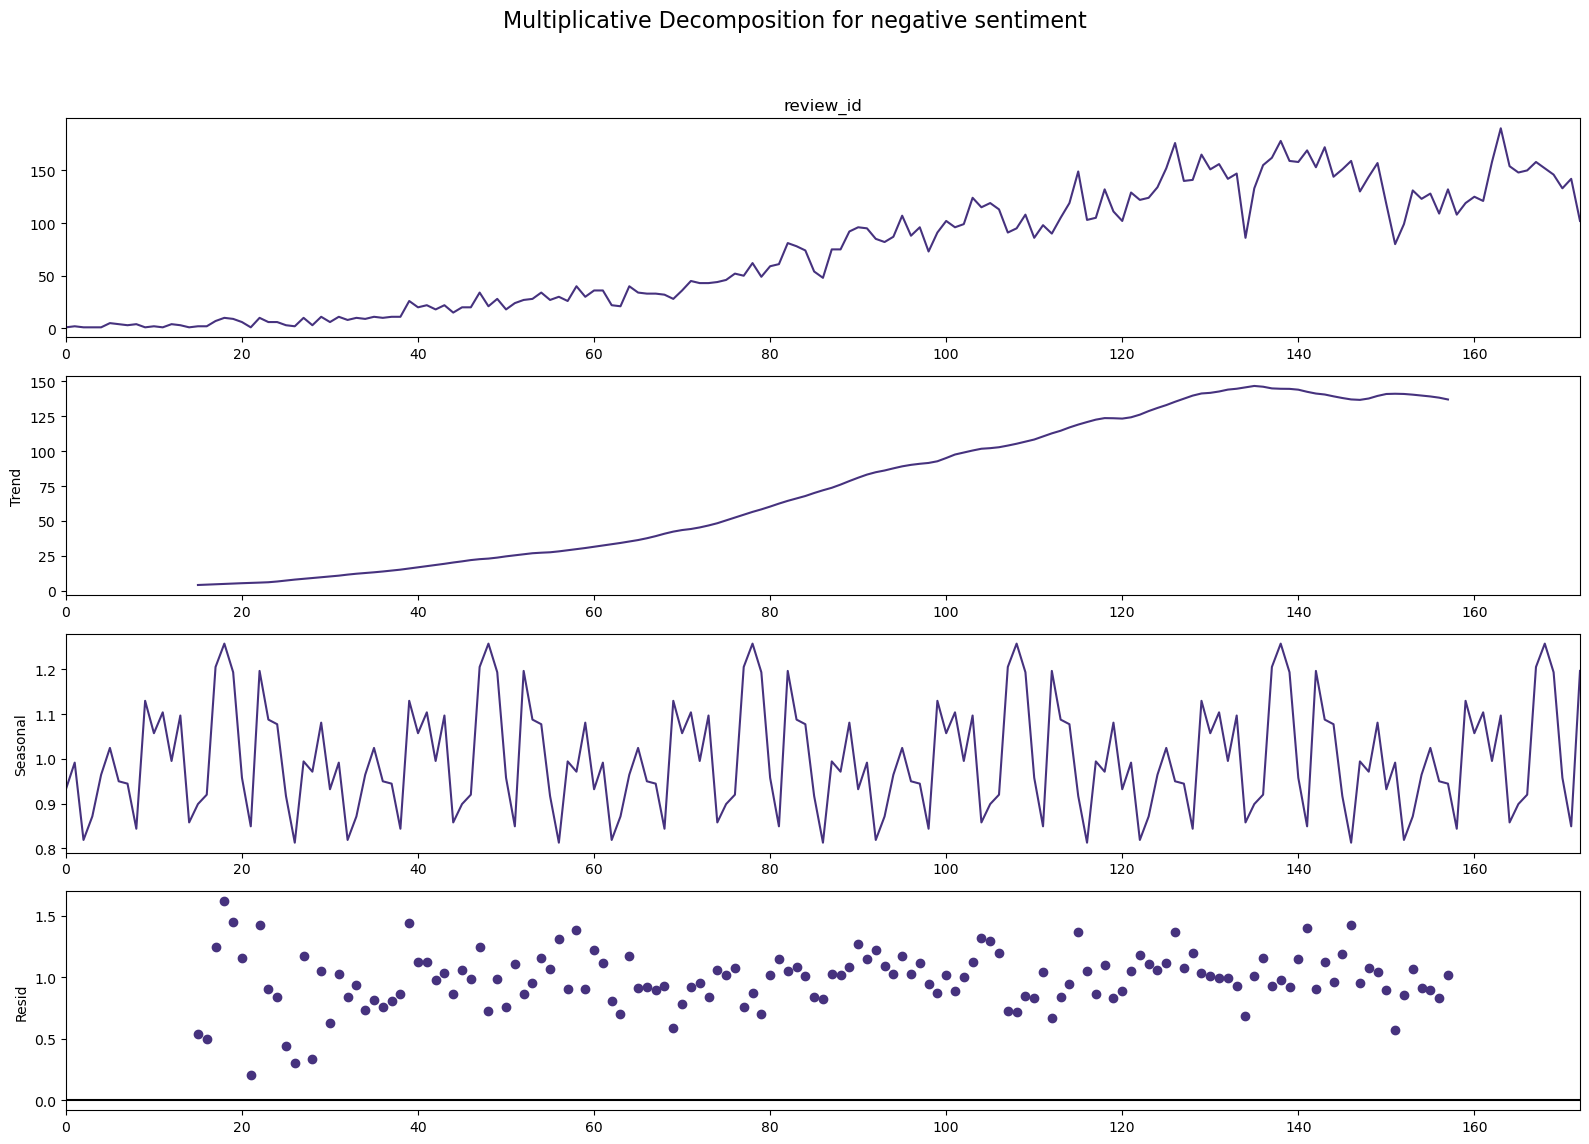

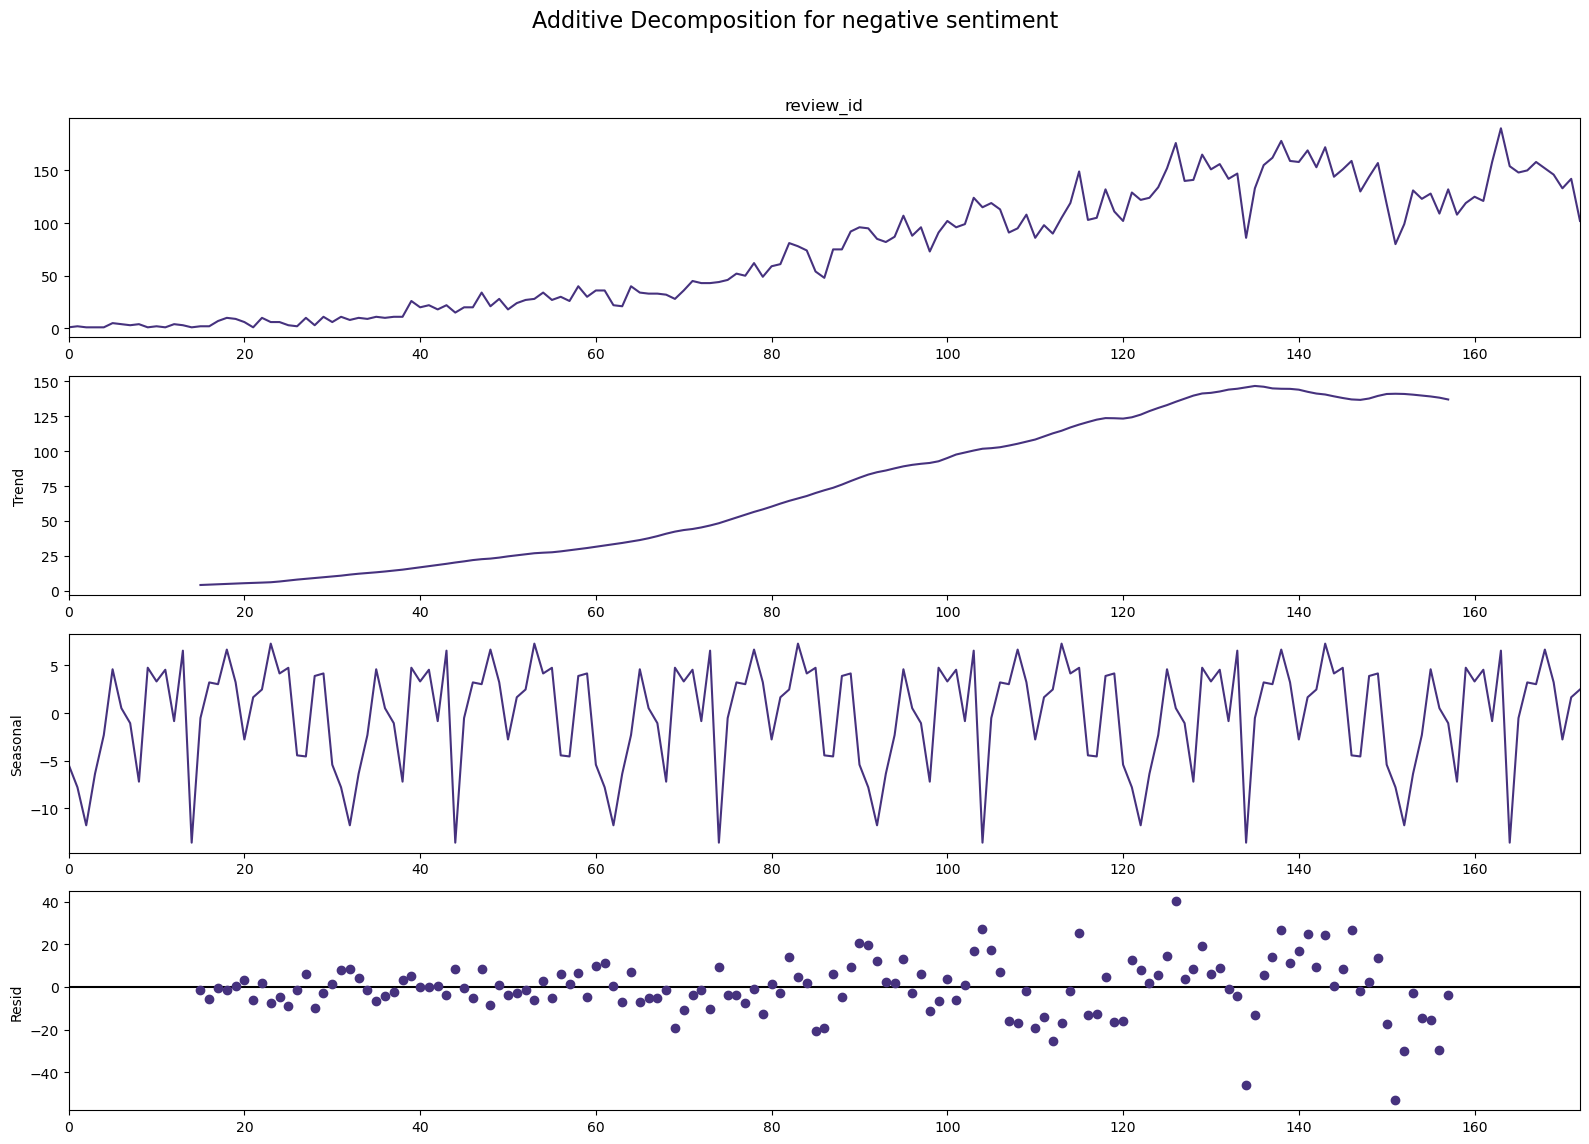

In [32]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(neg_pp['review_id'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(neg_pp['review_id'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for negative sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for negative sentiment', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [34]:
##### Decomposition of a time series can be performed by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual term.
##The seasonal_decompose in statsmodels implements this conveniently.

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_num['sentiment_count_diff'], model='multiplicative', period=30)
# Additive Decomposition
additive_decomposition = seasonal_decompose(df_num['sentiment_count_diff'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition for sentiment difference', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition for sentiment difference', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

# 3. DM - Data Modeling

In [35]:
pos_train = pos_pp[pos_pp['date'] < '2021-01-01']
pos_test = pos_pp[pos_pp['date'] >= '2021-01-01']

neg_train = neg_pp[neg_pp['date'] < '2021-01-01']
neg_test = neg_pp[neg_pp['date'] >= '2021-01-01']

## 3.1. DM - Baseline

### 3.1.1. DM - Baseline - Mean

In [36]:
pos_mean = pos_train['review_id'].mean()
neg_mean = neg_train['review_id'].mean()

### 3.1.2. DM - Baseline - Naive

In [37]:
pos_naive = pos_train['review_id'].values[-1]
neg_naive = neg_train['review_id'].values[-1]

## 3.2. DM - Exponential Smoothing

In [38]:
alpha = 0.9
beta = 0.9
gamma = 0.9

### 3.2.1. DM - Exponential Smoothing - Simple Exponential Smoothing

In [39]:
SimpleExpSmoothing_pos_model, SimpleExpSmoothing_pos_results = utils.ExponentialSmoothingModeling(model_type = 'simple', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha)

In [40]:
SimpleExpSmoothing_neg_model, SimpleExpSmoothing_neg_results = utils.ExponentialSmoothingModeling(model_type = 'simple', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha)

### 3.2.2. DM - Exponential Smoothing - Holt Exponential Smoothing

In [129]:
Holt_NotDamped_pos_model, Holt_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                            sentiment_data = pos_train,
                                                                            alpha = alpha, 
                                                                            beta = beta,
                                                                            damped = False)

Holt_Damped_pos_model, Holt_Damped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                      sentiment_data = pos_train, 
                                                                      alpha = alpha, 
                                                                      beta = beta,
                                                                      damped = True)

In [42]:
Holt_NotDamped_neg_model, Holt_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = neg_train,
                                                                                          alpha = alpha, 
                                                                                          beta = beta,
                                                                                          damped = False)

Holt_Damped_neg_model, Holt_Damped_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                sentiment_data = neg_train, 
                                                                                alpha = alpha, 
                                                                                beta = beta,
                                                                                damped = True)

### 3.2.3. DM - Exponential Smoothing - Holt-Winters Exponential Smoothing

In [43]:
HoltWinters_Add_NotDamped_pos_model, HoltWinters_Add_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = pos_train, 
                                                                                          decomposition_type = 'additive',
                                                                                          alpha = alpha, 
                                                                                          beta = beta, 
                                                                                          gamma = gamma,
                                                                                          damped = False)

HoltWinters_Add_Damped_pos_model, HoltWinters_Add_Damped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha, 
                                                                                    beta = beta, 
                                                                                    gamma = gamma,
                                                                                    decomposition_type = 'additive', 
                                                                                    damped = True)


HoltWinters_Multi_NotDamped_pos_model, HoltWinters_Multi_NotDamped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                          sentiment_data = pos_train, 
                                                                                          decomposition_type = 'multiplicative',
                                                                                          alpha = alpha, 
                                                                                          beta = beta, 
                                                                                          gamma = gamma,
                                                                                          damped = False)

HoltWinters_Multi_Damped_pos_model, HoltWinters_Multi_Damped_pos_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                    sentiment_data = pos_train, 
                                                                                    alpha = alpha, 
                                                                                    beta = beta, 
                                                                                    gamma = gamma,
                                                                                    decomposition_type = 'multiplicative', 
                                                                                    damped = True)

In [44]:
HoltWinters_Add_NotDamped_neg_model, HoltWinters_Add_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                        sentiment_data = neg_train, 
                                                                                                        decomposition_type = 'additive',
                                                                                                        alpha = alpha, 
                                                                                                        beta = beta, 
                                                                                                        gamma = gamma,
                                                                                                        damped = False)

HoltWinters_Add_Damped_neg_model, HoltWinters_Add_Damped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha, 
                                                                                                  beta = beta, 
                                                                                                  gamma = gamma,
                                                                                                  decomposition_type = 'additive', 
                                                                                                  damped = True)


HoltWinters_Multi_NotDamped_neg_model, HoltWinters_Multi_NotDamped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                        sentiment_data = neg_train, 
                                                                                                        decomposition_type = 'multiplicative',
                                                                                                        alpha = alpha, 
                                                                                                        beta = beta, 
                                                                                                        gamma = gamma,
                                                                                                        damped = False)

HoltWinters_Multi_Damped_neg_model, HoltWinters_Multi_Damped_neg_results = utils.ExponentialSmoothingModeling(model_type = 'holt', 
                                                                                                  sentiment_data = neg_train, 
                                                                                                  alpha = alpha, 
                                                                                                  beta = beta, 
                                                                                                  gamma = gamma,
                                                                                                  decomposition_type = 'multiplicative', 
                                                                                                  damped = True)

## 3.3. DM - ARIMA

In [45]:
# fit model
model_pos = ARIMA(pos_train['review_id'], order=(12,12,6))  #p,d,q
results_pos = model_pos.fit()
# summary of fit model
print(results_pos.summary())

c:\Users\cmigu\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\cmigu\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error.

In [46]:
# fit model
model_neg = ARIMA(neg_train['review_id'], order=(12,12,6))  #p,d,q
results_neg = model_neg.fit()
# summary of fit model
print(results_neg.summary())

c:\Users\cmigu\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              review_id   No. Observations:                  160
Model:               ARIMA(12, 12, 6)   Log Likelihood                -912.539
Date:                Tue, 03 Oct 2023   AIC                           1863.078
Time:                        21:56:09   BIC                           1920.025
Sample:                             0   HQIC                          1886.215
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4255      0.105    -23.157      0.000      -2.631      -2.220
ar.L2         -3.2035      0.238    -13.464      0.000      -3.670      -2.737
ar.L3         -2.7364      0.295     -9.283      0.0

## 3.4. DM - Regression

In [47]:
pos_pp_reg_train = pos_pp_reg[pos_pp_reg['date'] < '2021-01-01']
pos_pp_reg_test = pos_pp_reg[pos_pp_reg['date'] >= '2021-01-01']

neg_pp_reg_train = neg_pp_reg[pos_pp_reg['date'] < '2021-01-01']
neg_pp_reg_test = neg_pp_reg[neg_pp_reg['date'] >= '2021-01-01']

X_train_pos, y_train_pos = pos_pp_reg_train.drop(columns=['review_id', 'date']), pos_pp_reg_train['review_id']
X_train_neg, y_train_neg = neg_pp_reg_train.drop(columns=['review_id', 'date']), neg_pp_reg_train['review_id']

scaler_pos = StandardScaler()
scaler_pos.fit(X_train_pos)
X_train_pos = scaler_pos.transform(X_train_pos)

scaler_neg = StandardScaler()
scaler_neg.fit(X_train_neg)
X_train_neg = scaler_neg.transform(X_train_neg)

C:\Users\cmigu\AppData\Local\Temp\ipykernel_21324\3158071143.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_pp_reg_train = neg_pp_reg[pos_pp_reg['date'] < '2021-01-01']


In [48]:
model_pos = LinearRegression()
LineaRegression_pos = model_pos.fit(X_train_pos, y_train_pos)

model_neg = LinearRegression()
LineaRegression_neg = model_neg.fit(X_train_neg, y_train_neg)

In [49]:
display(LineaRegression_pos.score(X_train_pos, y_train_pos))
display(LineaRegression_neg.score(X_train_neg, y_train_neg))

0.9668856894998369

0.9360624334520691

# 4. ME - Model Evaluation

#### Regression Model Evaluation

Metrics for Positive Model:
Mean Squared Error (MSE): 32706.81
Mean Absolute Error (MAE): 154.65
R-squared (R2): -15.48


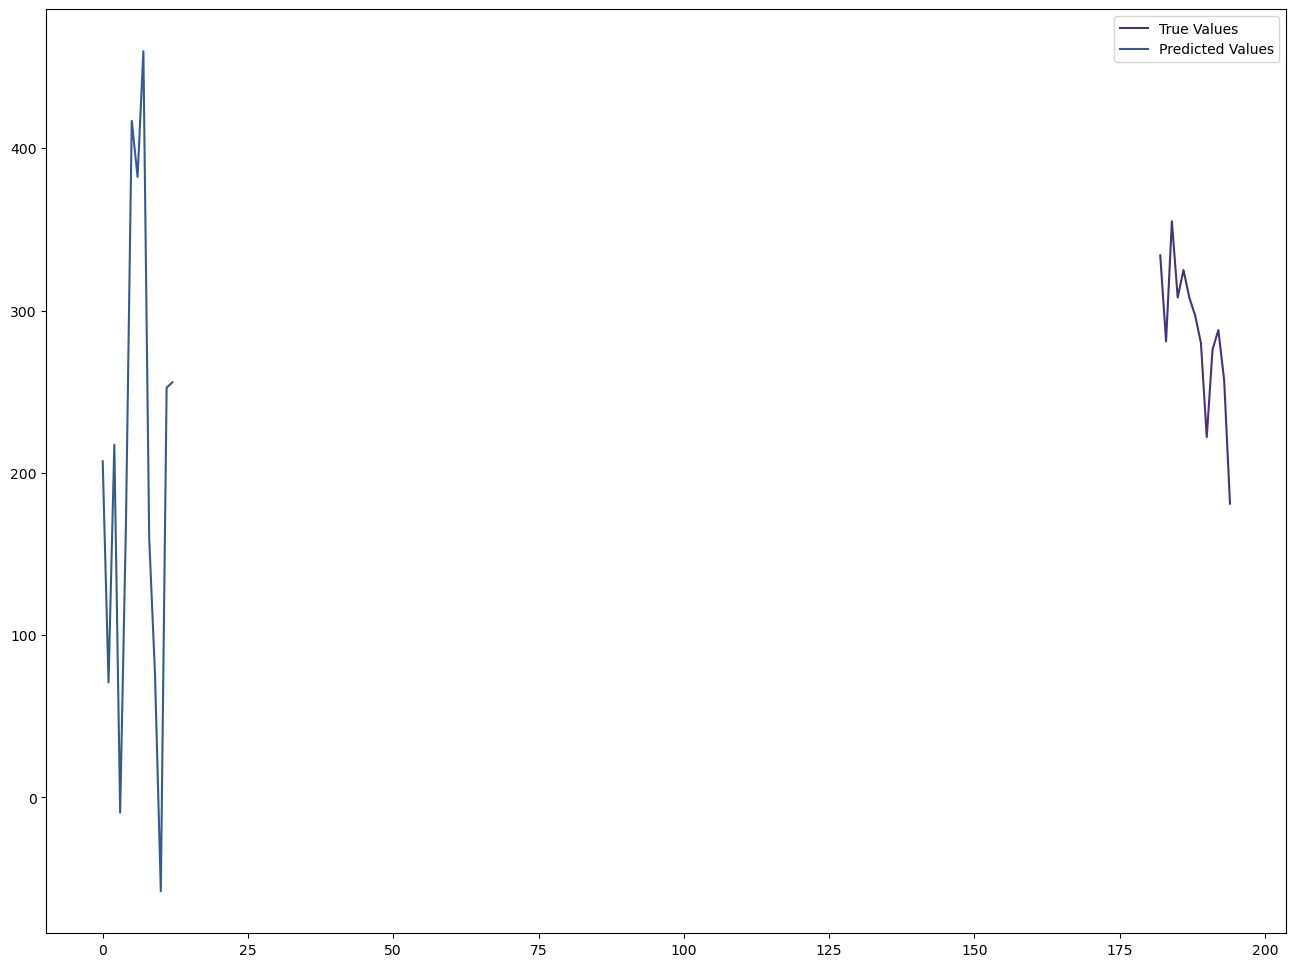

In [119]:
# Transform the test data using the same scaler
X_test_pos, y_test_pos = pos_pp_reg_test.drop(columns=['review_id', 'date']), pos_pp_reg_test['review_id']

# Use the previously fitted scalers
X_test_pos_scaled = scaler_pos.transform(X_test_pos)

# Make predictions for the test set
y_pred_pos = LineaRegression_pos.predict(X_test_pos_scaled)

# Evaluation metrics for positive model
lr_mse_pos = mean_squared_error(y_test_pos, y_pred_pos)
lr_mae_pos = mean_absolute_error(y_test_pos, y_pred_pos)
lr_r2_pos = r2_score(y_test_pos, y_pred_pos)

print("Metrics for Positive Model:")
print(f'Mean Squared Error (MSE): {lr_mse_pos:.2f}')
print(f'Mean Absolute Error (MAE): {lr_mae_pos:.2f}')
print(f'R-squared (R2): {lr_r2_pos:.2f}')

# Plotting
plt.plot(y_test_pos, label='True Values')
plt.plot(y_pred_pos, label='Predicted Values')
plt.legend()
plt.show()


Metrics for Positive Model:
Mean Squared Error (MSE): 73191.58
Mean Absolute Error (MAE): 270.16
R-squared (R2): -171.90


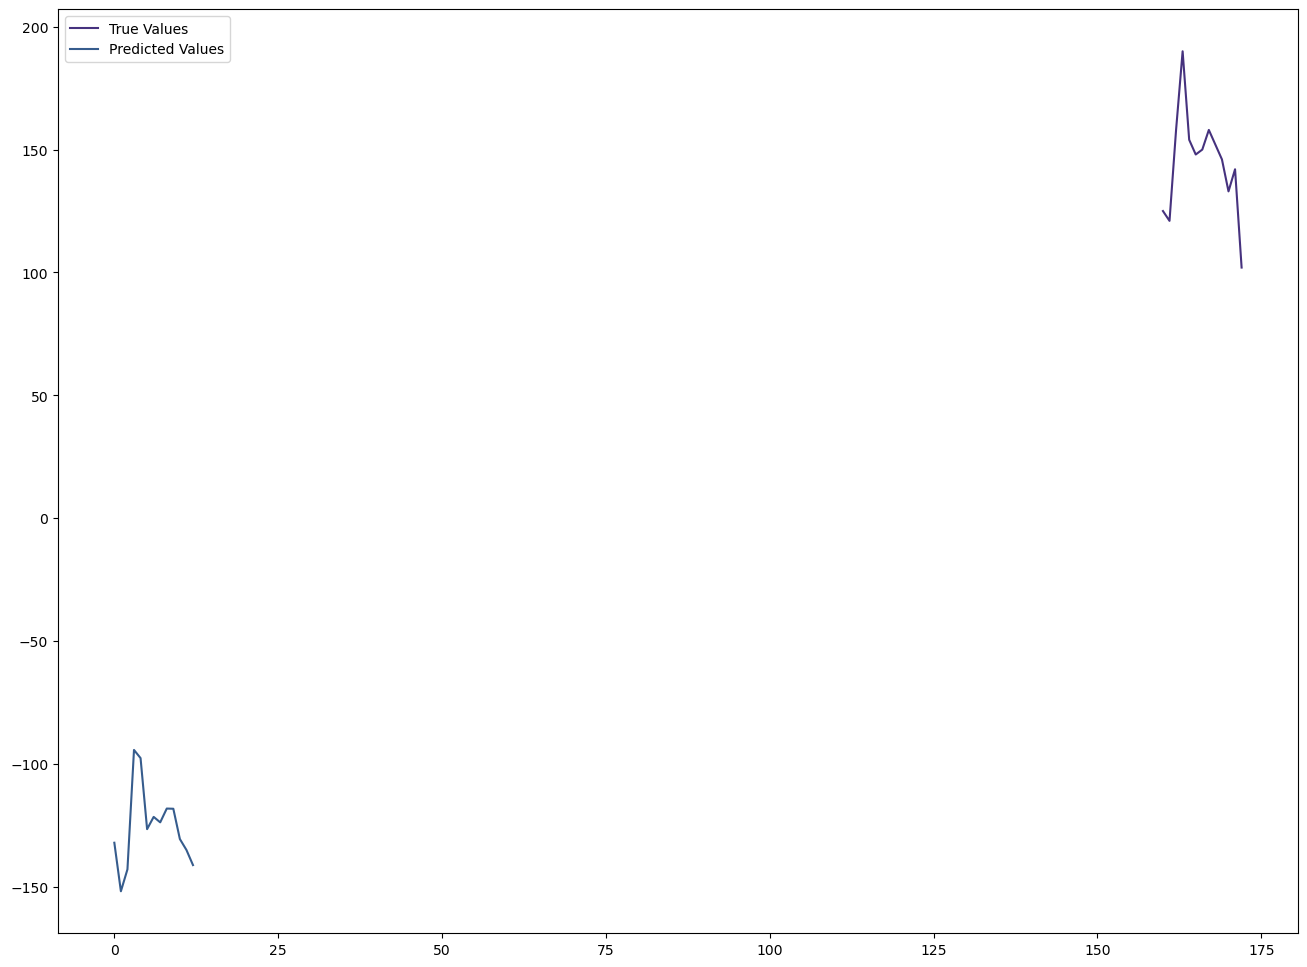

In [118]:
# Transform the test data using the same scaler
X_test_neg, y_test_neg = neg_pp_reg_test.drop(columns=['review_id', 'date']), neg_pp_reg_test['review_id']

# Use the previously fitted scalers
X_test_neg_scaled = scaler_neg.transform(X_test_neg)

# Make predictions for the test set
y_pred_neg = LineaRegression_neg.predict(X_test_neg_scaled)
# Evaluation metrics for positive model
lr_mse_neg = mean_squared_error(y_test_neg, y_pred_neg)
lr_mae_neg = mean_absolute_error(y_test_neg, y_pred_neg)
lr_r2_neg = r2_score(y_test_neg, y_pred_neg)

print("Metrics for Positive Model:")
print(f'Mean Squared Error (MSE): {lr_mse_neg:.2f}')
print(f'Mean Absolute Error (MAE): {lr_mae_neg:.2f}')
print(f'R-squared (R2): {lr_r2_neg:.2f}')

# Plotting
plt.plot(y_test_neg, label='True Values')
plt.plot(y_pred_neg, label='Predicted Values')
plt.legend()
plt.show()

#### ARIMA Evaluation

In [62]:
# Make predictions on the test set
y_pred_neg = results_neg.predict(start=0, end=len(neg_test)-1, typ='levels')

# Evaluation metrics for the negative model
mse_neg = mean_squared_error(neg_test, y_pred_neg)
mae_neg = mean_absolute_error(neg_test, y_pred_neg)
r2_neg = r2_score(neg_test, y_pred_neg)

print("Metrics for Negative ARIMA Model:")
print(f'Mean Squared Error (MSE): {mse_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_neg:.2f}')
print(f'R-squared (R2): {r2_neg:.2f}')

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[int64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>)

#### Exponential Smoothing - Simple Exponential Smoothing

Metrics for Positive Simple Exponential Smoothing Model:
Mean Squared Error (MSE): 82769.28
Mean Absolute Error (MAE): 284.17
R-squared (R2): -40.71


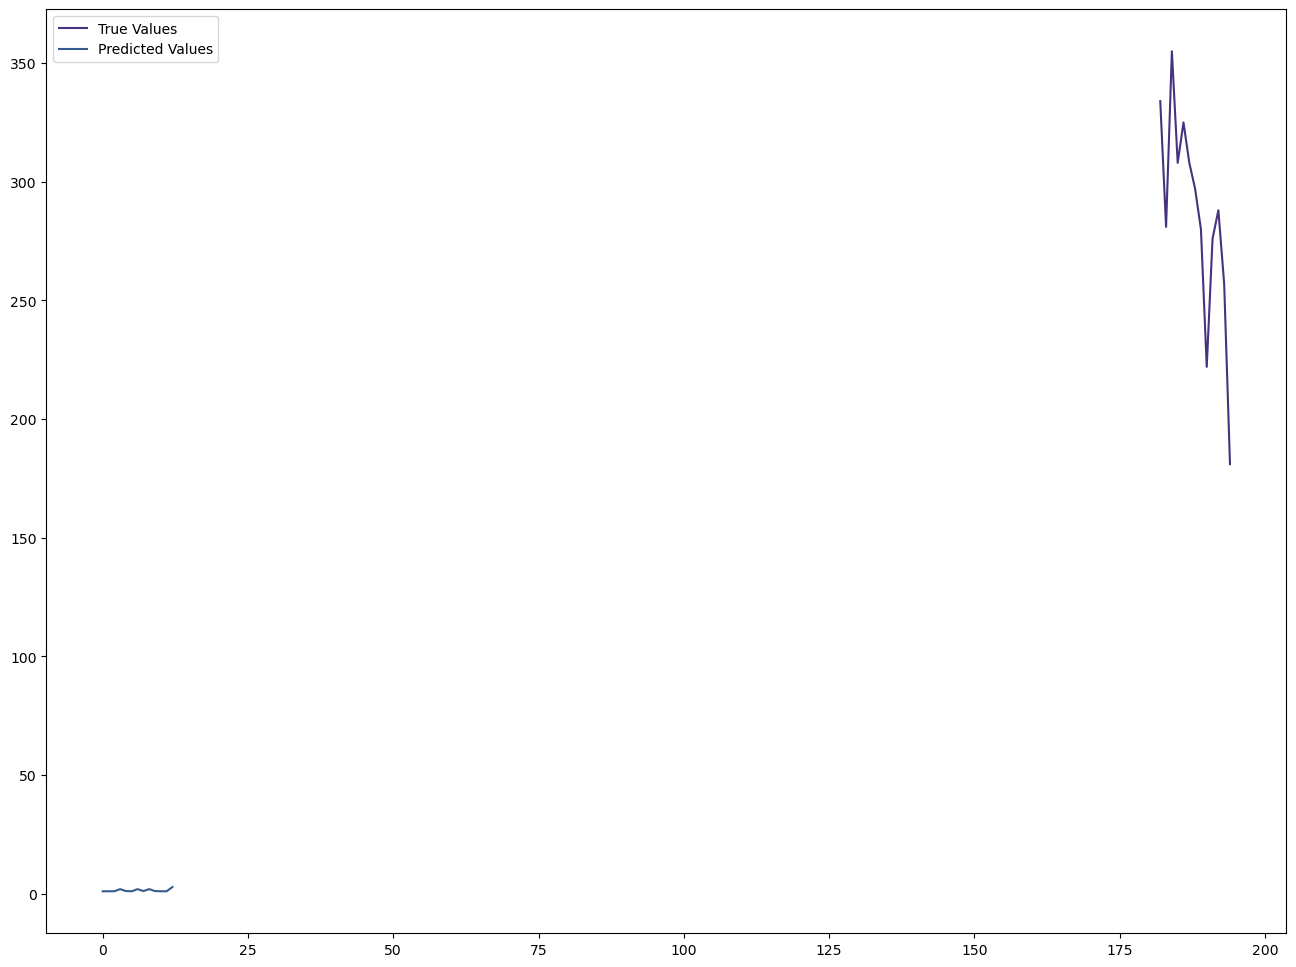

In [122]:
# Make predictions on the test set
y_pred_pos = SimpleExpSmoothing_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for positive model
mse_pos = mean_squared_error(y_test_pos, y_pred_pos)
mae_pos = mean_absolute_error(y_test_pos, y_pred_pos)
r2_pos = r2_score(y_test_pos, y_pred_pos)

print("Metrics for Positive Simple Exponential Smoothing Model:")
print(f'Mean Squared Error (MSE): {mse_pos:.2f}')
print(f'Mean Absolute Error (MAE): {mae_pos:.2f}')
print(f'R-squared (R2): {r2_pos:.2f}')

# Plotting
plt.plot(y_test_pos, label='True Values')
plt.plot(y_pred_pos, label='Predicted Values')
plt.legend()
plt.show()

Metrics for negative Simple Exponential Smoothing Model:
Mean Squared Error (MSE): 20705.17
Mean Absolute Error (MAE): 142.45
R-squared (R2): -47.91


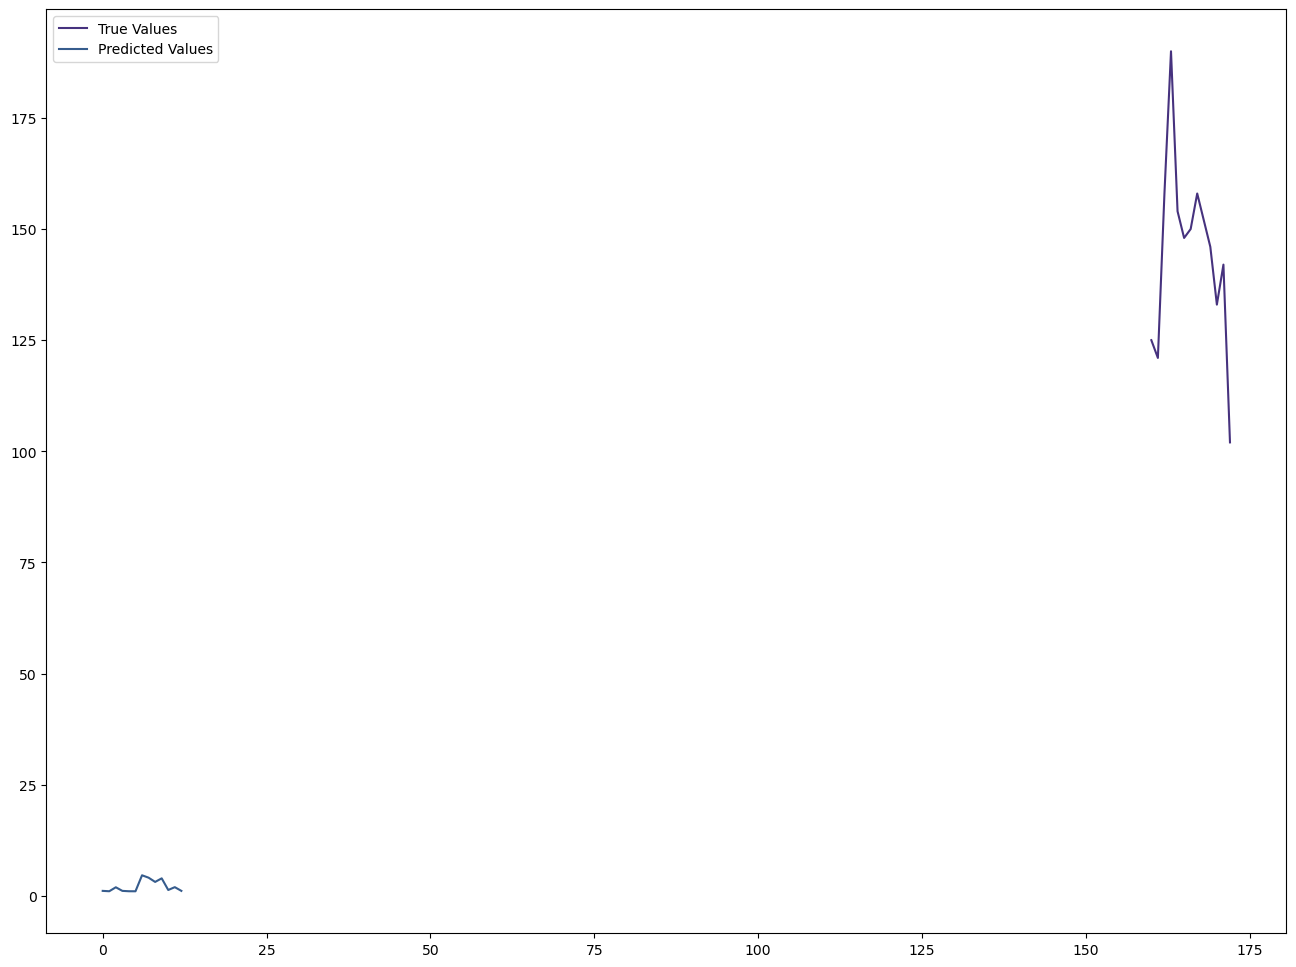

In [123]:
# Make predictions on the test set
y_pred_neg = SimpleExpSmoothing_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for negative model
mse_neg = mean_squared_error(y_test_neg, y_pred_neg)
mae_neg = mean_absolute_error(y_test_neg, y_pred_neg)
r2_neg = r2_score(y_test_neg, y_pred_neg)

print("Metrics for negative Simple Exponential Smoothing Model:")
print(f'Mean Squared Error (MSE): {mse_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_neg:.2f}')
print(f'R-squared (R2): {r2_neg:.2f}')

# Plotting
plt.plot(y_test_neg, label='True Values')
plt.plot(y_pred_neg, label='Predicted Values')
plt.legend()
plt.show()

#### Holt Exponential Smoothing

Metrics for Not-Damped Holt Model:
Mean Squared Error (MSE): 82717.12
Mean Absolute Error (MAE): 284.02
R-squared (R2): -40.68

Metrics for Damped Holt Model:
Mean Squared Error (MSE): 82730.80
Mean Absolute Error (MAE): 284.05
R-squared (R2): -40.69


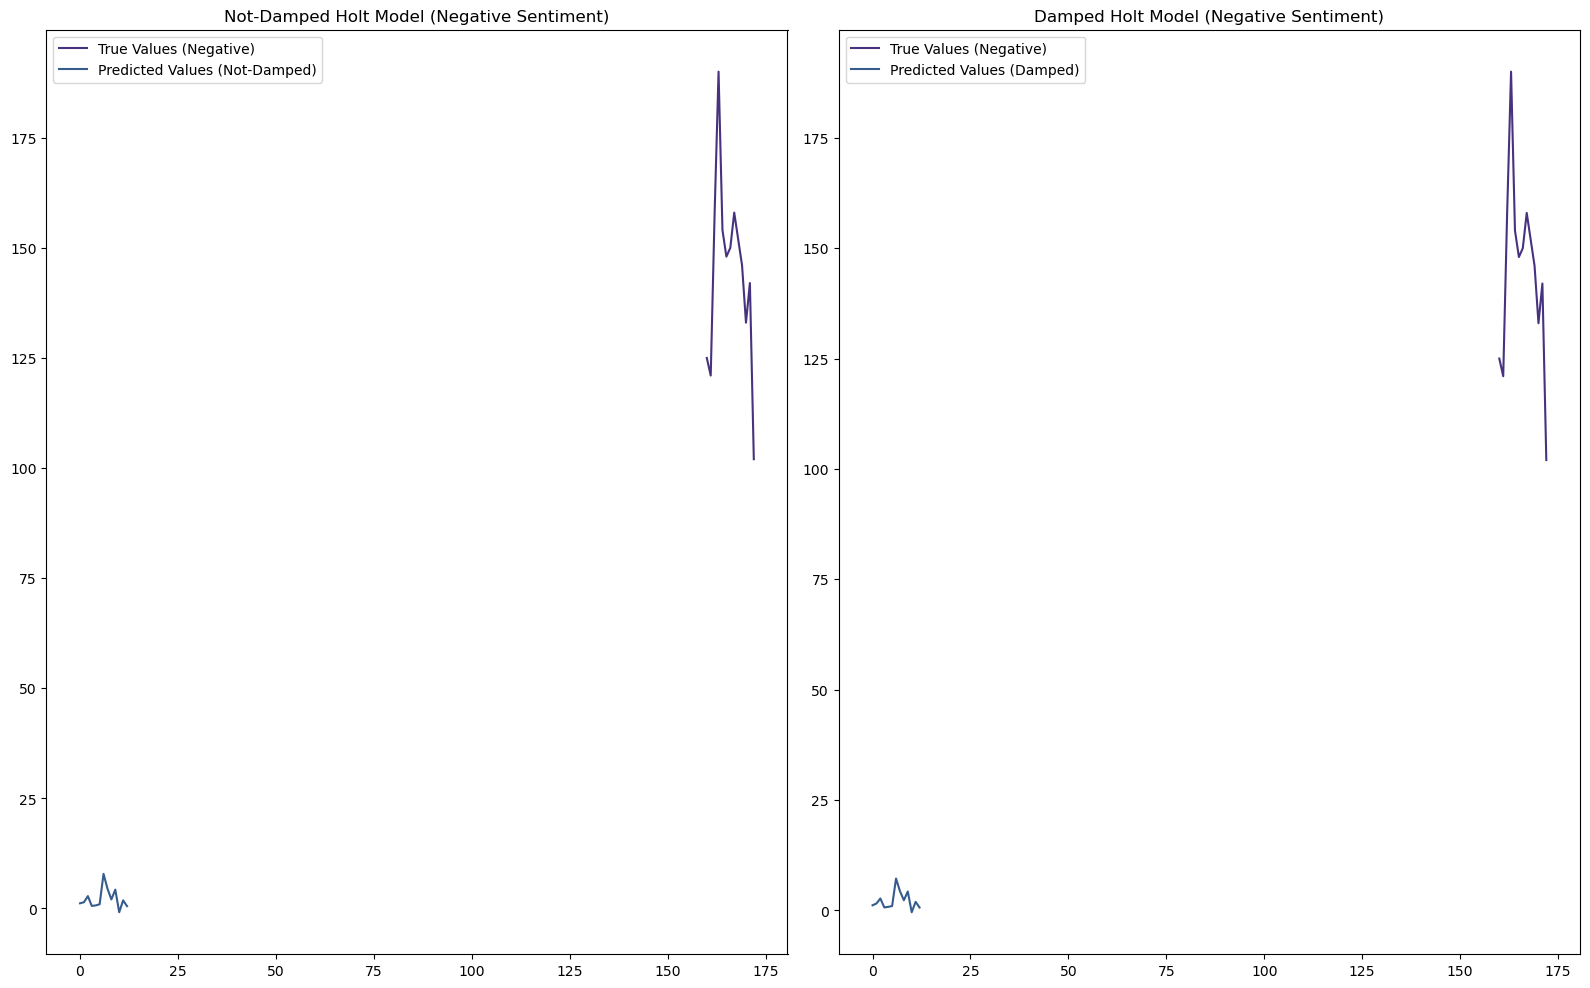

In [130]:
# Make predictions on the test set for the not-damped Holt model
y_pred_not_damped = Holt_NotDamped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for not-damped Holt model
mse_not_damped = mean_squared_error(y_test_pos, y_pred_not_damped)
mae_not_damped = mean_absolute_error(y_test_pos, y_pred_not_damped)
r2_not_damped = r2_score(y_test_pos, y_pred_not_damped)

print("Metrics for Not-Damped Holt Model:")
print(f'Mean Squared Error (MSE): {mse_not_damped:.2f}')
print(f'Mean Absolute Error (MAE): {mae_not_damped:.2f}')
print(f'R-squared (R2): {r2_not_damped:.2f}')

# Make predictions on the test set for the damped Holt model
y_pred_damped = Holt_Damped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for damped Holt model
mse_damped = mean_squared_error(y_test_pos, y_pred_damped)
mae_damped = mean_absolute_error(y_test_pos, y_pred_damped)
r2_damped = r2_score(y_test_pos, y_pred_damped)

print("\nMetrics for Damped Holt Model:")
print(f'Mean Squared Error (MSE): {mse_damped:.2f}')
print(f'Mean Absolute Error (MAE): {mae_damped:.2f}')
print(f'R-squared (R2): {r2_damped:.2f}')

# Plotting for not-damped Holt model
plt.subplot(1, 2, 1)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_not_damped_neg, label='Predicted Values (Not-Damped)')
plt.legend()
plt.title('Not-Damped Holt Model (Negative Sentiment)')

# Plotting for damped Holt model
plt.subplot(1, 2, 2)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_damped_neg, label='Predicted Values (Damped)')
plt.legend()
plt.title('Damped Holt Model (Negative Sentiment)')

plt.tight_layout()  # Adjust layout for better spacing
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin
plt.show()


Metrics for Not-Damped Holt Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.54
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86

Metrics for Damped Holt Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.52
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86


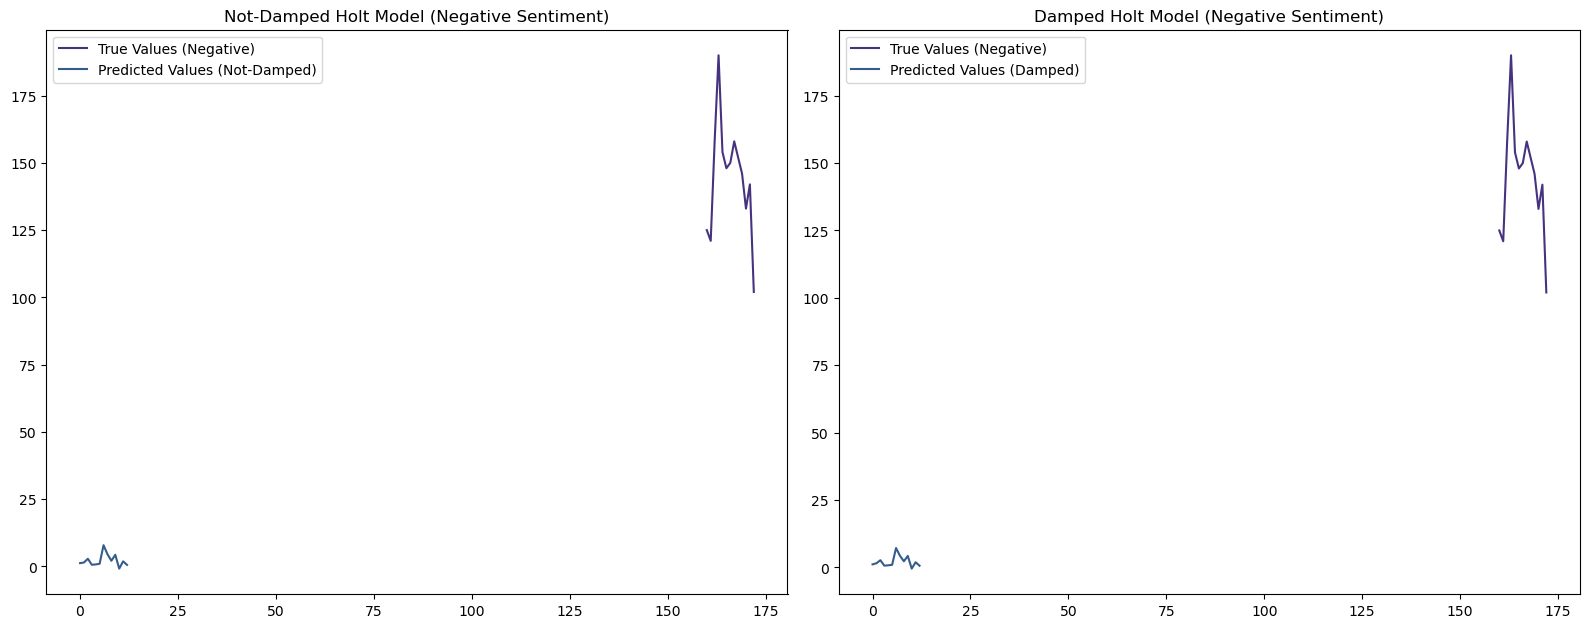

In [125]:
# Make predictions on the test set for the not-damped Holt model
y_pred_not_damped_neg = Holt_NotDamped_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for not-damped Holt model
mse_not_damped_neg = mean_squared_error(y_test_neg, y_pred_not_damped_neg)
mae_not_damped_neg = mean_absolute_error(y_test_neg, y_pred_not_damped_neg)
r2_not_damped_neg = r2_score(y_test_neg, y_pred_not_damped_neg)

print("Metrics for Not-Damped Holt Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_not_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_not_damped_neg:.2f}')
print(f'R-squared (R2): {r2_not_damped_neg:.2f}')

# Make predictions on the test set for the damped Holt model
y_pred_damped_neg = Holt_Damped_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for damped Holt model
mse_damped_neg = mean_squared_error(y_test_neg, y_pred_damped_neg)
mae_damped_neg = mean_absolute_error(y_test_neg, y_pred_damped_neg)
r2_damped_neg = r2_score(y_test_neg, y_pred_damped_neg)

print("\nMetrics for Damped Holt Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_damped_neg:.2f}')
print(f'R-squared (R2): {r2_damped_neg:.2f}')

# Plotting for not-damped Holt model
plt.subplot(1, 2, 1)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_not_damped_neg, label='Predicted Values (Not-Damped)')
plt.legend()
plt.title('Not-Damped Holt Model (Negative Sentiment)')

# Plotting for damped Holt model
plt.subplot(1, 2, 2)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_damped_neg, label='Predicted Values (Damped)')
plt.legend()
plt.title('Damped Holt Model (Negative Sentiment)')

plt.tight_layout()  # Adjust layout for better spacing
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom margin
plt.show()



#### Holt-Winter Evaluation

In [74]:
# Make predictions on the test set for the additive not-damped Holt-Winters model
y_pred_add_not_damped_pos = HoltWinters_Add_NotDamped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for additive not-damped Holt-Winters model
mse_add_not_damped_pos = mean_squared_error(y_test_pos, y_pred_add_not_damped_pos)
mae_add_not_damped_pos = mean_absolute_error(y_test_pos, y_pred_add_not_damped_pos)
r2_add_not_damped_pos = r2_score(y_test_pos, y_pred_add_not_damped_pos)

print("Metrics for Additive Not-Damped Holt-Winters Model (Positive Sentiment):")
print(f'Mean Squared Error (MSE): {mse_add_not_damped_pos:.2f}')
print(f'Mean Absolute Error (MAE): {mae_add_not_damped_pos:.2f}')
print(f'R-squared (R2): {r2_add_not_damped_pos:.2f}')


# Make predictions on the test set for the additive damped Holt-Winters model
y_pred_add_damped_pos = HoltWinters_Add_Damped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for additive damped Holt-Winters model
mse_add_damped_pos = mean_squared_error(y_test_pos, y_pred_add_damped_pos)
mae_add_damped_pos = mean_absolute_error(y_test_pos, y_pred_add_damped_pos)
r2_add_damped_pos = r2_score(y_test_pos, y_pred_add_damped_pos)

print("\nMetrics for Additive Damped Holt-Winters Model (Positive Sentiment):")
print(f'Mean Squared Error (MSE): {mse_add_damped_pos:.2f}')
print(f'Mean Absolute Error (MAE): {mae_add_damped_pos:.2f}')
print(f'R-squared (R2): {r2_add_damped_pos:.2f}')


# Make predictions on the test set for the multiplicative not-damped Holt-Winters model
y_pred_multi_not_damped_pos = HoltWinters_Multi_NotDamped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for multiplicative not-damped Holt-Winters model
mse_multi_not_damped_pos = mean_squared_error(y_test_pos, y_pred_multi_not_damped_pos)
mae_multi_not_damped_pos = mean_absolute_error(y_test_pos, y_pred_multi_not_damped_pos)
r2_multi_not_damped_pos = r2_score(y_test_pos, y_pred_multi_not_damped_pos)

print("\nMetrics for Multiplicative Not-Damped Holt-Winters Model (Positive Sentiment):")
print(f'Mean Squared Error (MSE): {mse_multi_not_damped_pos:.2f}')
print(f'Mean Absolute Error (MAE): {mae_multi_not_damped_pos:.2f}')
print(f'R-squared (R2): {r2_multi_not_damped_pos:.2f}')

# Make predictions on the test set for the multiplicative damped Holt-Winters model
y_pred_multi_damped_pos = HoltWinters_Multi_Damped_pos_results.predict(start=0, end=len(pos_test)-1)

# Evaluation metrics for multiplicative damped Holt-Winters model
mse_multi_damped_pos = mean_squared_error(y_test_pos, y_pred_multi_damped_pos)
mae_multi_damped_pos = mean_absolute_error(y_test_pos, y_pred_multi_damped_pos)
r2_multi_damped_pos = r2_score(y_test_pos, y_pred_multi_damped_pos)

print("\nMetrics for Multiplicative Damped Holt-Winters Model (Positive Sentiment):")
print(f'Mean Squared Error (MSE): {mse_multi_damped_pos:.2f}')
print(f'Mean Absolute Error (MAE): {mae_multi_damped_pos:.2f}')
print(f'R-squared (R2): {r2_multi_damped_pos:.2f}')


Metrics for Additive Not-Damped Holt-Winters Model (Positive Sentiment):
Mean Squared Error (MSE): 82717.12
Mean Absolute Error (MAE): 284.02
R-squared (R2): -40.68

Metrics for Additive Damped Holt-Winters Model (Positive Sentiment):
Mean Squared Error (MSE): 82730.80
Mean Absolute Error (MAE): 284.05
R-squared (R2): -40.69

Metrics for Multiplicative Not-Damped Holt-Winters Model (Positive Sentiment):
Mean Squared Error (MSE): 82717.12
Mean Absolute Error (MAE): 284.02
R-squared (R2): -40.68

Metrics for Multiplicative Damped Holt-Winters Model (Positive Sentiment):
Mean Squared Error (MSE): 82730.80
Mean Absolute Error (MAE): 284.05
R-squared (R2): -40.69


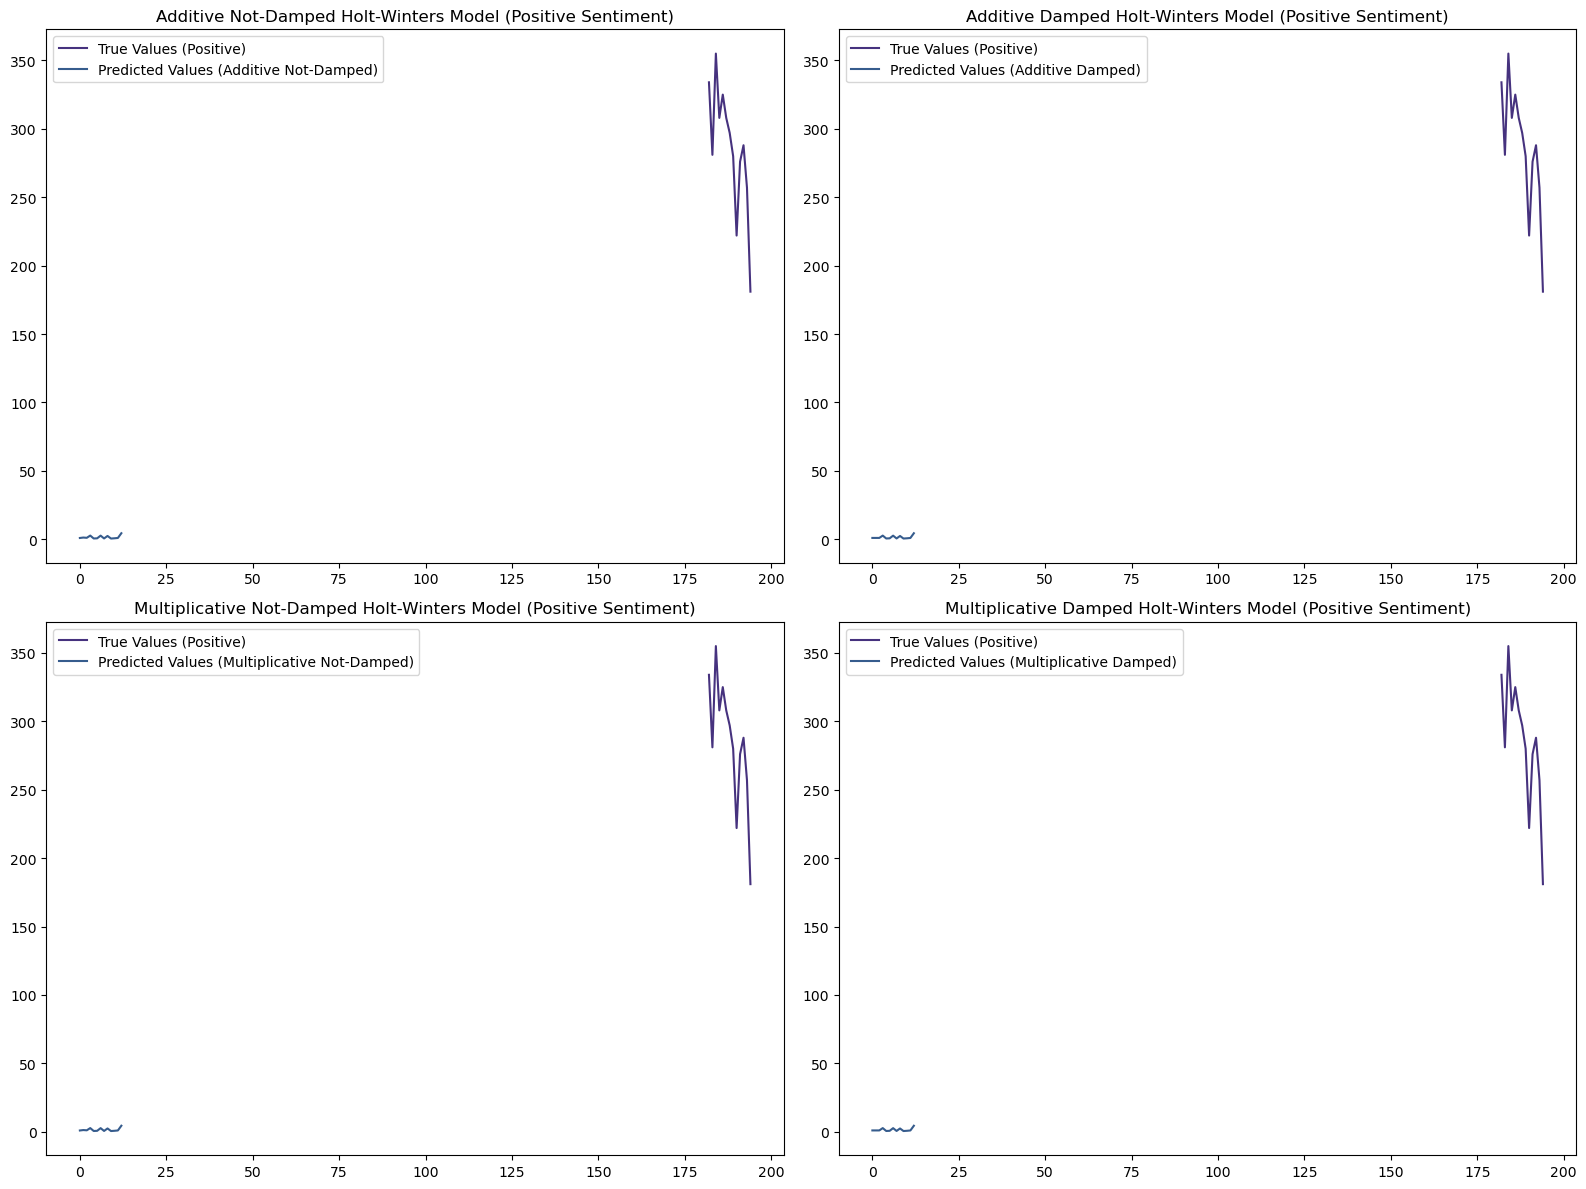

In [75]:
# Plotting for additive not-damped Holt-Winters model
plt.subplot(2, 2, 1)
plt.plot(y_test_pos, label='True Values (Positive)')
plt.plot(y_pred_add_not_damped_pos, label='Predicted Values (Additive Not-Damped)')
plt.legend()
plt.title('Additive Not-Damped Holt-Winters Model (Positive Sentiment)')

# Plotting for additive damped Holt-Winters model
plt.subplot(2, 2, 2)
plt.plot(y_test_pos, label='True Values (Positive)')
plt.plot(y_pred_add_damped_pos, label='Predicted Values (Additive Damped)')
plt.legend()
plt.title('Additive Damped Holt-Winters Model (Positive Sentiment)')

# Plotting for multiplicative not-damped Holt-Winters model
plt.subplot(2, 2, 3)
plt.plot(y_test_pos, label='True Values (Positive)')
plt.plot(y_pred_multi_not_damped_pos, label='Predicted Values (Multiplicative Not-Damped)')
plt.legend()
plt.title('Multiplicative Not-Damped Holt-Winters Model (Positive Sentiment)')

# Plotting for multiplicative damped Holt-Winters model
plt.subplot(2, 2, 4)
plt.plot(y_test_pos, label='True Values (Positive)')
plt.plot(y_pred_multi_damped_pos, label='Predicted Values (Multiplicative Damped)')
plt.legend()
plt.title('Multiplicative Damped Holt-Winters Model (Positive Sentiment)')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


Metrics for Additive Not-Damped Holt-Winters Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.54
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86

Metrics for Additive Damped Holt-Winters Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.52
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86

Metrics for Multiplicative Not-Damped Holt-Winters Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.54
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86

Metrics for Multiplicative Damped Holt-Winters Model (Negative Sentiment):
Mean Squared Error (MSE): 20684.52
Mean Absolute Error (MAE): 142.39
R-squared (R2): -47.86


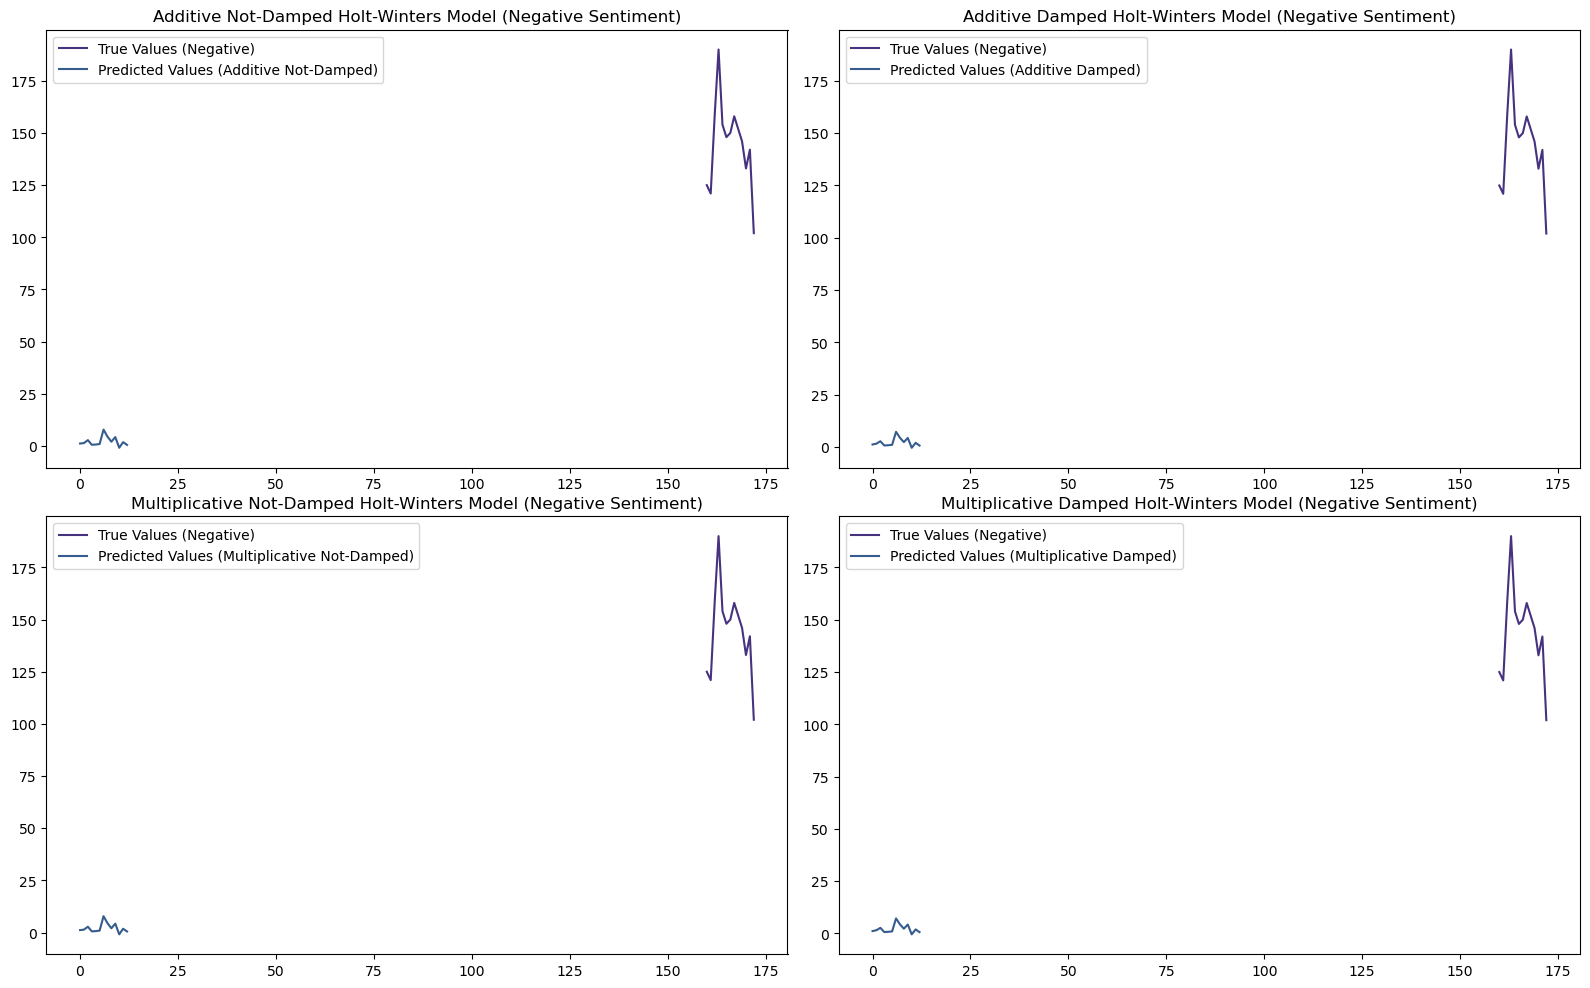

In [84]:
# Make predictions on the test set for the additive not-damped Holt-Winters model
y_pred_add_not_damped_neg = HoltWinters_Add_NotDamped_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for additive not-damped Holt-Winters model
mse_add_not_damped_neg = mean_squared_error(y_test_neg, y_pred_add_not_damped_neg)
mae_add_not_damped_neg = mean_absolute_error(y_test_neg, y_pred_add_not_damped_neg)
r2_add_not_damped_neg = r2_score(y_test_neg, y_pred_add_not_damped_neg)

print("Metrics for Additive Not-Damped Holt-Winters Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_add_not_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_add_not_damped_neg:.2f}')
print(f'R-squared (R2): {r2_add_not_damped_neg:.2f}')

# Plotting for additive not-damped Holt-Winters model
plt.subplot(2, 2, 1)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_add_not_damped_neg, label='Predicted Values (Additive Not-Damped)')
plt.legend()
plt.title('Additive Not-Damped Holt-Winters Model (Negative Sentiment)')

# Make predictions on the test set for the additive damped Holt-Winters model
y_pred_add_damped_neg = HoltWinters_Add_Damped_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for additive damped Holt-Winters model
mse_add_damped_neg = mean_squared_error(y_test_neg, y_pred_add_damped_neg)
mae_add_damped_neg = mean_absolute_error(y_test_neg, y_pred_add_damped_neg)
r2_add_damped_neg = r2_score(y_test_neg, y_pred_add_damped_neg)

print("\nMetrics for Additive Damped Holt-Winters Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_add_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_add_damped_neg:.2f}')
print(f'R-squared (R2): {r2_add_damped_neg:.2f}')

# Plotting for additive damped Holt-Winters model
plt.subplot(2, 2, 2)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_add_damped_neg, label='Predicted Values (Additive Damped)')
plt.legend()
plt.title('Additive Damped Holt-Winters Model (Negative Sentiment)')

# Make predictions on the test set for the multiplicative not-damped Holt-Winters model
y_pred_multi_not_damped_neg = HoltWinters_Multi_NotDamped_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for multiplicative not-damped Holt-Winters model
mse_multi_not_damped_neg = mean_squared_error(y_test_neg, y_pred_multi_not_damped_neg)
mae_multi_not_damped_neg = mean_absolute_error(y_test_neg, y_pred_multi_not_damped_neg)
r2_multi_not_damped_neg = r2_score(y_test_neg, y_pred_multi_not_damped_neg)

print("\nMetrics for Multiplicative Not-Damped Holt-Winters Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_multi_not_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_multi_not_damped_neg:.2f}')
print(f'R-squared (R2): {r2_multi_not_damped_neg:.2f}')

# Plotting for multiplicative not-damped Holt-Winters model
plt.subplot(2, 2, 3)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_multi_not_damped_neg, label='Predicted Values (Multiplicative Not-Damped)')
plt.legend()
plt.title('Multiplicative Not-Damped Holt-Winters Model (Negative Sentiment)')

# Make predictions on the test set for the multiplicative damped Holt-Winters model
y_pred_multi_damped_neg = HoltWinters_Multi_Damped_neg_results.predict(start=0, end=len(neg_test)-1)

# Evaluation metrics for multiplicative damped Holt-Winters model
mse_multi_damped_neg = mean_squared_error(y_test_neg, y_pred_multi_damped_neg)
mae_multi_damped_neg = mean_absolute_error(y_test_neg, y_pred_multi_damped_neg)
r2_multi_damped_neg = r2_score(y_test_neg, y_pred_multi_damped_neg)

print("\nMetrics for Multiplicative Damped Holt-Winters Model (Negative Sentiment):")
print(f'Mean Squared Error (MSE): {mse_multi_damped_neg:.2f}')
print(f'Mean Absolute Error (MAE): {mae_multi_damped_neg:.2f}')
print(f'R-squared (R2): {r2_multi_damped_neg:.2f}')

# Plotting for multiplicative damped Holt-Winters model
plt.subplot(2, 2, 4)
plt.plot(y_test_neg, label='True Values (Negative)')
plt.plot(y_pred_multi_damped_neg, label='Predicted Values (Multiplicative Damped)')
plt.legend()
plt.title('Multiplicative Damped Holt-Winters Model (Negative Sentiment)')

plt.tight_layout()  # Adjust layout for better spacing
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin
plt.show()


#### List of Results

In [134]:
# Create a list to store the Holt-Winters metrics table data
holt_metrics_table = [
    ["Lineaer Regression - Positives", lr_mse_pos, lr_mae_pos, lr_r2_pos],
    ["Lineaer Regression - Negatives", lr_mse_neg, lr_mae_neg, lr_r2_neg],
    [],
    ["Simple Exponential Smoothing - Positives", mse_pos, mae_pos, r2_pos],
    ["Simple Exponential Smoothing - Negatives", mse_neg, mae_neg, r2_neg],
    [],
    ["Holt Exponential Smoothing"],
    ["Not-damped Holt model - Positives", mse_not_damped, mae_not_damped, r2_not_damped],
    ["Not-damped Holt model - Negatives", mse_not_damped_neg, mae_not_damped_neg, r2_not_damped_neg],
    ["Damped Holt model - Positives", mse_damped, mae_damped, r2_damped],
    ["Damped Holt model - Negatives", mse_damped_neg, mae_damped_neg, r2_damped_neg],
    [],
    ["Holt-Winters model"],
    ["Additive Not-Damped - Negatives", mse_add_not_damped_neg, mae_add_not_damped_neg, r2_add_not_damped_neg],
    ["Additive Damped - Negatives", mse_add_damped_neg, mae_add_damped_neg, r2_add_damped_neg],
    ["Multiplicative Not-Damped - Negatives", mse_multi_not_damped_neg, mae_multi_not_damped_neg, r2_multi_not_damped_neg],
    ["Multiplicative Damped - Negatives", mse_multi_damped_neg, mae_multi_damped_neg, r2_multi_damped_neg],
    ["Additive Not-Damped - Positives", mse_add_not_damped_pos, mae_add_not_damped_pos, r2_add_not_damped_pos],
    ["Additive Damped - Positives", mse_add_damped_pos, mae_add_damped_pos, r2_add_damped_pos],
    ["Multiplicative Not-Damped - Positives", mse_multi_not_damped_pos, mae_multi_not_damped_pos, r2_multi_not_damped_pos],
    ["Multiplicative Damped - Positives", mse_multi_damped_pos, mae_multi_damped_pos, r2_multi_damped_pos],
    [],
    ["ARIMA"],
    [],
    [],
]

# Define the table headers
headers = ["Model", "MSE", "MAE", "R2"]

# Print the Holt-Winters metrics table using tabulate
print("Holt-Winters Metrics:")
table = tabulate(holt_metrics_table, headers, tablefmt="fancy_grid")
print(table)


Holt-Winters Metrics:
╒══════════════════════════════════════════╤═════════╤═════════╤═══════════╕
│ Model                                    │     MSE │     MAE │        R2 │
╞══════════════════════════════════════════╪═════════╪═════════╪═══════════╡
│ Lineaer Regression - Positives           │ 32706.8 │ 154.651 │  -15.4807 │
├──────────────────────────────────────────┼─────────┼─────────┼───────────┤
│ Lineaer Regression - Negatives           │ 73191.6 │ 270.159 │ -171.897  │
├──────────────────────────────────────────┼─────────┼─────────┼───────────┤
│                                          │         │         │           │
├──────────────────────────────────────────┼─────────┼─────────┼───────────┤
│ Simple Exponential Smoothing - Positives │ 82769.3 │ 284.168 │  -40.7067 │
├──────────────────────────────────────────┼─────────┼─────────┼───────────┤
│ Simple Exponential Smoothing - Negatives │ 20705.2 │ 142.455 │  -47.9108 │
├──────────────────────────────────────────┼─────────┼